In [ ]:
from google.cloud import bigquery
import pandas as pd
import polars as pl
import plotly.express as px
import os
import gc
import numpy as np
from google.colab import drive
from google.colab import auth
import re

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = '/content/drive/MyDrive/Thesis/Codes/Data'
save_file_address = f'Graph_v2_1'
# read_file_address = f'/MIMIC_preprocessing'

# Generate CSV with Query

## Set Up

In [ ]:
def process_query_in_chunks(query, output_dir, output_filename, drive_dir = dir, page_size=1_000_000):
    job = client.query(query)
    result = job.result(page_size=page_size)
    schema_fields = {field.name: field.field_type for field in result.schema}

    os.makedirs(output_dir, exist_ok=True)

    chunk_id = 0
    global_schema = None
    temp_chunk_files = []
    # print(len(result.pages))
    for page in result.pages:
        print(f"Processing chunk {chunk_id}...")
        rows = [dict(row.items()) for row in page]
        if not rows:
            print(f"No rows in chunk {chunk_id}. Skipping...")
            continue

        pdf = pd.DataFrame(rows)

        for col, bq_type in schema_fields.items():
            if col not in pdf.columns:
                continue
            if bq_type in ("STRING", "DATE", "DATETIME", "TIMESTAMP"):
                pdf[col] = pdf[col].astype("string")
            elif bq_type in ("INTEGER", "INT64"):
                pdf[col] = pd.to_numeric(pdf[col], errors="coerce").astype("Int64")
            elif bq_type in ("FLOAT", "FLOAT64", "NUMERIC", "BIGNUMERIC"):
                pdf[col] = pd.to_numeric(pdf[col], errors="coerce").astype("float64")
            elif bq_type in ("BOOLEAN", "BOOL"):
                pdf[col] = pdf[col].astype("boolean")

        try:
            pl_df = pl.from_pandas(pdf, include_index=False)
        except Exception as e:
            print(f"Could not convert to Polars DataFrame: {e}")
            continue

        if global_schema is None:
            global_schema = pl_df.schema
        else:
            try:
                pl_df = pl_df.cast(global_schema)
            except Exception as e:
                print(f"Schema casting failed in chunk {chunk_id}: {e}")
                continue

        chunk_file_path = f"{output_dir}/chunk_{output_filename}_{chunk_id}.parquet"
        pl_df.write_parquet(chunk_file_path, compression="zstd")
        temp_chunk_files.append(chunk_file_path)

        del pdf, pl_df
        gc.collect()
        chunk_id += 1

    if not temp_chunk_files:
        print("No chunks were successfully processed.")
        return

    print("Combining all chunks...")
    try:
        all_chunks = pl.scan_parquet(temp_chunk_files)
    except Exception as e:
        print(f"Failed to scan combined chunks: {e}")
        return

    drive_dir = f'{dir}/{output_dir}'
    os.makedirs(drive_dir, exist_ok=True)
    final_output_path = os.path.join(drive_dir, output_filename + '.parquet')

    print(f"Saving combined Parquet to: {final_output_path}")
    all_chunks.sink_parquet(final_output_path)

    print("Process completed successfully.")


In [ ]:
auth.authenticate_user()

project_id = input('gpc projec id: ')
client = bigquery.Client(project= project_id)

#thesis-462417-470712

gpc projec id: thesis-462417-470712


## Stay


### Make

In [ ]:
chart_missed_ids = """
SELECT stay_id
FROM `physionet-data.mimiciv_3_1_icu.icustays` icu
JOIN `physionet-data.mimiciv_3_1_hosp.admissions` adm
USING (hadm_id)
WHERE los IS NOT NULL AND (icu.intime < adm.admittime OR icu.intime > adm.dischtime);
"""

process_query_in_chunks(chart_missed_ids, save_file_address, 'icu_stay_misslead_ids')

#### Choose Scores

Should Be Used in Chapter 3

In [ ]:
icu_stay = """
SELECT
  icu.subject_id,
  icu.hadm_id,
  icu.stay_id,
  first_careunit as icu_careunit,
  IF(edregtime IS NOT NULL,1 , 0) as er_register,
  -- intime as icu_intime,
  -- outtime as icu_outtime,
  -- admiss.admittime as hosp_admission_time,
  -- admiss.dischtime as hosp_discharge_time,
  -- DATETIME_DIFF(admiss.dischtime , admiss.admittime, MINUTE)/60/24 as hosp_discharge_to_admission_time_diff,
  admission_type as hosp_admission_type,
  admission_location as hosp_admission_location,
  -- edregtime as ed_registration_time,
  -- edouttime as ed_outcome_time,
  DATETIME_DIFF(intime, admiss.admittime, MINUTE)/60/24 as icu_admission_to_hosp_admission,
  COALESCE(DATETIME_DIFF(intime, edregtime, MINUTE)/60/24, 0) as icu_admission_to_er_admission,
  -- DATETIME_DIFF(intime, admiss.admittime, MINUTE)/60/24 as icu_admission_to_hosp_admission,
  los
FROM `physionet-data.mimiciv_3_1_icu.icustays` as icu
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.admissions` as admiss
  USING(hadm_id)
WHERE DATETIME_DIFF(intime, admiss.admittime, MINUTE)  >= 0
      AND los IS NOT NULL
  --  AND los > 5/24
"""

process_query_in_chunks(icu_stay, save_file_address, 'icu_stay')

In [ ]:


icu_stay = """
SELECT
  icu.subject_id,
  icu.hadm_id,
  icu.stay_id,
  first_careunit as icu_careunit,
  IF(edregtime IS NOT NULL,1 , 0) as er_register,
  -- intime as icu_intime,
  -- outtime as icu_outtime,
  -- admiss.admittime as hosp_admission_time,
  -- admiss.dischtime as hosp_discharge_time,
  -- DATETIME_DIFF(admiss.dischtime , admiss.admittime, MINUTE)/60/24 as hosp_discharge_to_admission_time_diff,
  admission_type as hosp_admission_type,
  admission_location as hosp_admission_location,
  -- edregtime as ed_registration_time,
  -- edouttime as ed_outcome_time,
  DATETIME_DIFF(intime, admiss.admittime, MINUTE)/60/24 as icu_admission_to_hosp_admission,
  COALESCE(DATETIME_DIFF(intime, edregtime, MINUTE)/60/24, 0) as icu_admission_to_er_admission,
  -- DATETIME_DIFF(intime, admiss.admittime, MINUTE)/60/24 as icu_admission_to_hosp_admission,
  los
FROM `physionet-data.mimiciv_3_1_icu.icustays` as icu
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.admissions` as admiss
  USING(hadm_id)
WHERE DATETIME_DIFF(intime, admiss.admittime, MINUTE)  >= 0
      AND los IS NOT NULL
      -- AND los > 5/24
"""

process_query_in_chunks(icu_stay, save_file_address, 'icu_stay')


icu_stay_full_scores = """
SELECT
icu.subject_id,
icu.hadm_id,
icu.stay_id,
first_careunit as icu_careunit,
IF(edregtime IS NOT NULL,1 , 0) as er_register,
-- intime as icu_intime,
-- outtime as icu_outtime,
-- admiss.admittime as hosp_admission_time,
-- admiss.dischtime as hosp_discharge_time,
-- DATETIME_DIFF(admiss.dischtime , admiss.admittime, MINUTE)/60/24 as hosp_discharge_to_admission_time_diff,
admission_type as hosp_admission_type,
admission_location as hosp_admission_location,
-- edregtime as ed_registration_time,
-- edouttime as ed_outcome_time,
DATETIME_DIFF(intime, admiss.admittime, MINUTE)/60/24 as icu_admission_to_hosp_admission,
COALESCE(DATETIME_DIFF(intime, edregtime, MINUTE)/60/24, 0) as icu_admission_to_er_admission,
-- DATETIME_DIFF(intime, admiss.admittime, MINUTE)/60/24 as icu_admission_to_hosp_admission,
lods.lods as lods,
lods.neurologic as lods_neurologic,
lods.hematologic as lods_hematologic,
lods.cardiovascular as lods_cardiovascular,
lods.renal as lods_renal,
lods.pulmonary as lods_pulmonary,
lods.hematologic as lods_hematologic,
lods.hepatic as lods_hepatic,
sofa.sofa as sofa,
sofa.respiration as sofa_respiration,
sofa.coagulation as sofa_coagulation,
sofa.liver as sofa_liver,
sofa.cardiovascular as sofa_cardiovascular,
sofa.cns as sofa_cns,
sofa.renal as sofa_renal,
meld.meld_initial as meld_initial,
meld.meld as meld,
meld.rrt as meld_rrt,
meld.creatinine_max as meld_creatinine_max,
meld.bilirubin_total_max as meld_bilirubin_total_max,
meld.inr_max as meld_inr_max,
meld.sodium_min as meld_sodium_min,
apsiii.apsiii as apsiii,
apsiii.apsiii_prob as apsiii_prob,
apsiii.hr_score as apsiii_hr_score,
apsiii.mbp_score as apsiii_mbp_score,
apsiii.temp_score as apsiii_temp_score,
apsiii.resp_rate_score as apsiii_resp_rate_score,
apsiii.pao2_aado2_score as apsiii_pao2_aado2_score,
apsiii.hematocrit_score as apsiii_hematocrit_score,
apsiii.wbc_score as apsiii_wbc_score,
apsiii.creatinine_score as apsiii_creatinine_score,
apsiii.uo_score as apsiii_uo_score,
apsiii.bun_score as apsiii_bun_score,
apsiii.sodium_score as apsiii_sodium_score,
apsiii.albumin_score as apsiii_albumin_score,
apsiii.bilirubin_score as apsiii_bilirubin_score,
apsiii.glucose_score as apsiii_glucose_score,
apsiii.acidbase_score as apsiii_acidbase_score,
apsiii.gcs_score as apsiii_gcs_score,
oasis.oasis as oasis,
oasis.oasis_prob as oasis_prob,
oasis.age as oasis_age,
oasis.age_score as oasis_age_score,
oasis.preiculos as oasis_preiculos,
oasis.preiculos_score as oasis_preiculos_score,
oasis.gcs as oasis_gcs,
oasis.gcs_score as oasis_gcs_score,
oasis.heartrate as oasis_heartrate,
oasis.heart_rate_score as oasis_heart_rate_score,
oasis.meanbp as oasis_meanbp,
oasis.mbp_score as oasis_mbp_score,
oasis.resprate as oasis_resprate,
oasis.resp_rate_score as oasis_resp_rate_score,
oasis.`temp` as oasis_temp,
oasis.temp_score as oasis_temp_score,
oasis.urineoutput as oasis_urineoutput,
oasis.urineoutput_score as oasis_urineoutput_score,
oasis.mechvent as oasis_mechvent,
oasis.mechvent_score as oasis_mechvent_score,
oasis.electivesurgery as oasis_electivesurgery,
oasis.electivesurgery_score as oasis_electivesurgery_score,
los,
FROM `physionet-data.mimiciv_3_1_icu.icustays` as icu
LEFT JOIN `physionet-data.mimiciv_3_1_derived.lods` as lods
USING(stay_id)
LEFT JOIN `physionet-data.mimiciv_3_1_derived.meld` as meld
USING(stay_id)
LEFT JOIN `physionet-data.mimiciv_3_1_derived.first_day_sofa` as sofa
USING(stay_id)
LEFT JOIN `physionet-data.mimiciv_3_1_derived.apsiii` as apsiii
USING(stay_id)
LEFT JOIN `physionet-data.mimiciv_3_1_derived.oasis` as oasis
USING(stay_id)
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.admissions` as admiss
ON icu.hadm_id = admiss.hadm_id
WHERE DATETIME_DIFF(intime, admiss.admittime, MINUTE)  >= 0
      AND los IS NOT NULL
      -- AND los > 5/24

"""

process_query_in_chunks(icu_stay_scores, save_file_address, 'icu_stay_full_score')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance


def safe_log1p(x):
    x = np.asarray(x)
    x = np.clip(x, 0, None)
    return np.log1p(x)

df = df.copy()
df = df[df["los"].notna() & (df["los"] >= 0)].copy()
df["y_log"] = safe_log1p(df["los"])

BASE_CAT = ["icu_careunit", "hosp_admission_type", "hosp_admission_location"]
BASE_NUM = ["er_register", "icu_admission_to_hosp_admission", "icu_admission_to_er_admission"]

SCORES = ["apsiii", "oasis", "sofa", "lods", "meld", "meld_initial"]

APS_COMP = [c for c in df.columns if c.startswith("apsiii_") and c not in ["apsiii", "apsiii_prob"]]
OAS_COMP = [c for c in df.columns if c.startswith("oasis_") and c not in ["oasis", "oasis_prob"]]
SOFA_COMP = [c for c in df.columns if c.startswith("sofa_") and c != "sofa"]
LODS_COMP = [c for c in df.columns if c.startswith("lods_") and c != "lods"]
MELD_COMP = [c for c in df.columns if c.startswith("meld_") and c not in ["meld", "meld_initial"]]

SCORES = [c for c in SCORES if c in df.columns]

GROUP_COL = "subject_id"
TARGET = "y_log"


def missing_report(cols, title="Missingness report", top_n=50):
    cols = [c for c in cols if c in df.columns]
    rep = pd.DataFrame({
        "col": cols,
        "non_null": [df[c].notna().sum() for c in cols],
        "missing": [df[c].isna().sum() for c in cols],
        "missing_pct": [df[c].isna().mean() * 100 for c in cols],
    }).sort_values("missing_pct", ascending=False)

    print(f"\n=== {title} ===")
    print(rep.head(top_n).to_string(index=False))

    # Plot
    d = rep.head(top_n).iloc[::-1]
    fig = plt.figure(figsize=(10, max(4, 0.25 * len(d))))
    ax = fig.add_subplot(1, 1, 1)
    ax.barh(d["col"], d["missing_pct"])
    ax.set_title(f"{title} (Top {top_n} by missing %)")
    ax.set_xlabel("Missing %")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()
    return rep

miss_scores = missing_report(SCORES, "Scores missingness", top_n=30)
miss_aps = missing_report(APS_COMP, "APSIII components missingness", top_n=50)
miss_oas = missing_report(OAS_COMP, "OASIS components missingness", top_n=50)
miss_sof = missing_report(SOFA_COMP, "SOFA components missingness", top_n=50)
miss_lod = missing_report(LODS_COMP, "LODS components missingness", top_n=50)
miss_mel = missing_report(MELD_COMP, "MELD components missingness", top_n=50)

def corr_heatmap(cols, method="spearman", title="Correlation heatmap"):
    cols = [c for c in cols if c in df.columns]
    d = df[cols].copy()
    corr = d.corr(method=method)

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(corr.values, aspect="auto")
    ax.set_title(f"{title} ({method})")
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=45, ha="right")
    ax.set_yticklabels(cols)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()
    return corr

score_corr = corr_heatmap(SCORES, method="spearman", title="Scores redundancy")


def spearman_with_target(cols, target=TARGET, min_n=1000):
    rows = []
    for c in cols:
        if c not in df.columns:
            continue
        tmp = df[[c, target]].dropna()
        if len(tmp) < min_n:
            continue
        rho = tmp[c].corr(tmp[target], method="spearman")
        rows.append((c, float(rho), len(tmp), df[c].isna().mean()*100))
    out = pd.DataFrame(rows, columns=["feature", "spearman_rho", "n", "missing_pct"]).sort_values("spearman_rho", ascending=False)
    return out

def mutual_info_with_target(cols, target=TARGET, min_n=5000, random_state=42):
    cols = [c for c in cols if c in df.columns]
    X = df[cols].copy()
    y = df[target].copy()

    keep = []
    for c in cols:
        tmp = df[[c, target]].dropna()
        if len(tmp) >= min_n:
            keep.append(c)
    cols = keep
    if not cols:
        return pd.DataFrame(columns=["feature", "mi", "n", "missing_pct"])

    X = df[cols].copy()
    y = df[target].copy()
    X = X.apply(pd.to_numeric, errors="coerce")
    X = X.fillna(X.median(numeric_only=True))

    mi = mutual_info_regression(X.values, y.values, random_state=random_state)
    out = pd.DataFrame({
        "feature": cols,
        "mi": mi,
        "n": len(df),
        "missing_pct": [df[c].isna().mean()*100 for c in cols],
    }).sort_values("mi", ascending=False)
    return out

score_rho = spearman_with_target(SCORES, min_n=10000)
print("\n=== Scores Spearman vs log1p(LOS) ===")
print(score_rho.to_string(index=False))

score_mi = mutual_info_with_target(SCORES, min_n=20000)
print("\n=== Scores Mutual Information vs log1p(LOS) ===")
print(score_mi.to_string(index=False))

for name, cols in [
    ("APS components", APS_COMP),
    ("OASIS components", OAS_COMP),
    ("SOFA components", SOFA_COMP),
    ("LODS components", LODS_COMP),
    ("MELD components", MELD_COMP),
]:
    cols = [c for c in cols if c in df.columns]
    if not cols:
        continue
    rho = spearman_with_target(cols, min_n=5000).head(30)
    print(f"\n=== Top components by Spearman: {name} ===")
    print(rho.to_string(index=False))


def make_model(cat_cols, num_cols):
    cat_cols = [c for c in cat_cols if c in df.columns]
    num_cols = [c for c in num_cols if c in df.columns]

    pre = ColumnTransformer(
        transformers=[
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols),
            ("num", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("sc", StandardScaler())
            ]), num_cols),
        ],
        remainder="drop"
    )
    model = Ridge(alpha=3.0, random_state=42)
    return Pipeline([("pre", pre), ("model", model)])

def eval_feature_set(name, cat_cols, num_cols, target=TARGET, groups_col=GROUP_COL, n_splits=5):
    gkf = GroupKFold(n_splits=n_splits)
    X = df[cat_cols + num_cols].copy()
    y = df[target].values
    groups = df[groups_col].values

    pipe = make_model(cat_cols, num_cols)

    maes = []
    rmses = []
    r2s = []

    for tr, te in gkf.split(X, y, groups):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y[tr], y[te]
        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xte)

        maes.append(mean_absolute_error(yte, pred))
        rmses.append(np.sqrt(mean_squared_error(yte, pred)))
        r2s.append(r2_score(yte, pred))

    out = {
        "set": name,
        "mae_log": float(np.mean(maes)),
        "rmse_log": float(np.mean(rmses)),
        "r2_log": float(np.mean(r2s)),
        "mae_log_std": float(np.std(maes)),
        "n": len(df),
    }
    return out

SETS = []

SETS.append(("Base", BASE_CAT, BASE_NUM))

SETS.append(("Base + OASIS", BASE_CAT, BASE_NUM + ["oasis"]))

SETS.append(("Base + SOFA", BASE_CAT, BASE_NUM + ["sofa"]))

SETS.append(("Base + OASIS + SOFA", BASE_CAT, BASE_NUM + ["oasis", "sofa"]))

if "apsiii" in df.columns:
    SETS.append(("Base + APSIII", BASE_CAT, BASE_NUM + ["apsiii"]))

if "apsiii" in df.columns:
    SETS.append(("Base + APSIII + SOFA", BASE_CAT, BASE_NUM + ["apsiii", "sofa"]))

if "lods" in df.columns:
    SETS.append(("Base + LODS", BASE_CAT, BASE_NUM + ["lods"]))
if "meld" in df.columns:
    SETS.append(("Base + MELD", BASE_CAT, BASE_NUM + ["meld"]))

results = []
for name, cats, nums in SETS:
    nums = [c for c in nums if c in df.columns]
    results.append(eval_feature_set(name, cats, nums))

res_df = pd.DataFrame(results).sort_values("mae_log")
print("\n=== Ablation (GroupKFold) - lower MAE is better ===")
print(res_df.to_string(index=False))

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.bar(res_df["set"], res_df["mae_log"])
ax.set_title("Ablation: MAE on log1p(LOS) (GroupKFold)")
ax.set_ylabel("MAE (log1p days)")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.show()


def permutation_importance_on_best(best_set_name, cat_cols, num_cols, n_repeats=5):
    gkf = GroupKFold(n_splits=5)
    X = df[cat_cols + num_cols].copy()
    y = df[TARGET].values
    groups = df[GROUP_COL].values
    tr, te = next(gkf.split(X, y, groups))

    Xtr, Xte = X.iloc[tr], X.iloc[te]
    ytr, yte = y[tr], y[te]

    pipe = make_model(cat_cols, num_cols)
    pipe.fit(Xtr, ytr)

    r = permutation_importance(
        pipe, Xte, yte,
        n_repeats=n_repeats,
        random_state=42,
        scoring="neg_mean_absolute_error"
    )
    out = pd.DataFrame({
        "feature": X.columns,
        "importance": r.importances_mean,
        "importance_std": r.importances_std
    }).sort_values("importance", ascending=False)

    print(f"\n=== Permutation importance (raw columns) for: {best_set_name} ===")
    print(out.head(30).to_string(index=False))

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    top = out.head(20).iloc[::-1]
    ax.barh(top["feature"], top["importance"])
    ax.set_title(f"Permutation Importance (Top 20) - {best_set_name}")
    ax.set_xlabel("Importance (Δ MAE, higher = more important)")
    plt.tight_layout()
    plt.show()

    return out

best_row = res_df.iloc[0]
best_name = best_row["set"]
best_set = [s for s in SETS if s[0] == best_name][0]
_ = permutation_importance_on_best(best_name, best_set[1], best_set[2], n_repeats=3)


def decide_drop_candidates(feature_list, min_nonnull_frac=0.7, min_abs_rho=0.03):
    """
    min_nonnull_frac: حداقل درصد داده‌ی موجود (مثلاً 0.7 یعنی حداقل 70% non-null)
    min_abs_rho: حداقل |spearman| با log(LOS) برای اینکه ارزش داشته باشد
    """
    cols = [c for c in feature_list if c in df.columns]
    out = []
    for c in cols:
        nn_frac = df[c].notna().mean()
        tmp = df[[c, TARGET]].dropna()
        rho = tmp[c].corr(tmp[TARGET], method="spearman") if len(tmp) > 2000 else np.nan
        out.append((c, nn_frac, rho))
    d = pd.DataFrame(out, columns=["feature", "nonnull_frac", "spearman_rho"]).dropna()
    d["abs_rho"] = d["spearman_rho"].abs()
    drop = d[(d["nonnull_frac"] < min_nonnull_frac) & (d["abs_rho"] < min_abs_rho)].sort_values(["nonnull_frac", "abs_rho"])
    keep = d.drop(drop.index).sort_values("abs_rho", ascending=False)
    return keep, drop

keep_aps, drop_aps = decide_drop_candidates(APS_COMP, min_nonnull_frac=0.7, min_abs_rho=0.03)
print("\n=== APSIII components: DROP candidates (missing high + signal low) ===")
print(drop_aps.head(50).to_string(index=False))

keep_sofa, drop_sofa = decide_drop_candidates(SOFA_COMP, min_nonnull_frac=0.7, min_abs_rho=0.03)
print("\n=== SOFA components: DROP candidates (missing high + signal low) ===")
print(drop_sofa.head(50).to_string(index=False))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df = df.copy()
df = df[df["los"].notna() & (df["los"] >= 0)].copy()
df["y_log"] = np.log1p(df["los"].clip(lower=0))

GROUP_COL = "subject_id"
TARGET = "y_log"

drop_prefixes = ["apsiii_", "lods_", "meld_"]
drop_exact = ["apsiii", "apsiii_prob", "lods", "meld", "meld_initial"]

drop_cols = set()
for c in df.columns:
    if any(c.startswith(p) for p in drop_prefixes):
        drop_cols.add(c)
for c in drop_exact:
    if c in df.columns:
        drop_cols.add(c)

df_pruned = df.drop(columns=sorted(drop_cols), errors="ignore").copy()

print(f"Dropped {len(drop_cols)} columns.")
print("Remaining columns:", len(df_pruned.columns))


BASE_CAT = ["icu_careunit", "hosp_admission_type", "hosp_admission_location"]
BASE_NUM = ["er_register", "icu_admission_to_hosp_admission", "icu_admission_to_er_admission"]


KEEP_SCORES = ["oasis", "sofa"]

OPTIONAL_ADD = ["oasis_mechvent"]

def existing(cols):
    return [c for c in cols if c in df_pruned.columns]

BASE_CAT = existing(BASE_CAT)
BASE_NUM = existing(BASE_NUM)

SETS = [
    ("Base + OASIS + SOFA", BASE_CAT, existing(BASE_NUM + ["oasis", "sofa"])),
    ("Base + OASIS",        BASE_CAT, existing(BASE_NUM + ["oasis"])),
    ("Base + SOFA",         BASE_CAT, existing(BASE_NUM + ["sofa"])),
    ("Base + OASIS + SOFA + mechvent", BASE_CAT, existing(BASE_NUM + ["oasis", "sofa"] + OPTIONAL_ADD)),
]

SETS = [(n, c, x) for (n, c, x) in SETS if len(x) > 0]

print("\nFeature sets:")
for n, c, x in SETS:
    print(f"- {n}: cat={len(c)}, num={len(x)}")

def make_model(cat_cols, num_cols):
    pre = ColumnTransformer(
        transformers=[
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), cat_cols),
            ("num", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("sc", StandardScaler()),
            ]), num_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    model = Ridge(alpha=3.0, random_state=42)
    return Pipeline([("pre", pre), ("model", model)])

def eval_set(df_use, set_name, cat_cols, num_cols, seeds=(42, 43, 44), n_splits=5):
    """
    Evaluate MAE/RMSE/R2 on log1p(LOS) with patient-level GroupKFold.
    Seeds are used only for model randomness (Ridge has none) and for any tie-breaking later.
    Kept for consistency if you swap the model later.
    """
    X = df_use[cat_cols + num_cols].copy()
    y = df_use[TARGET].values
    groups = df_use[GROUP_COL].values

    rows = []
    for seed in seeds:
        gkf = GroupKFold(n_splits=n_splits)
        maes, rmses, r2s = [], [], []
        for tr, te in gkf.split(X, y, groups):
            pipe = make_model(cat_cols, num_cols)
            pipe.fit(X.iloc[tr], y[tr])
            pred = pipe.predict(X.iloc[te])

            maes.append(mean_absolute_error(y[te], pred))
            rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
            r2s.append(r2_score(y[te], pred))

        rows.append({
            "set": set_name,
            "seed": seed,
            "mae_log": float(np.mean(maes)),
            "rmse_log": float(np.mean(rmses)),
            "r2_log": float(np.mean(r2s)),
            "mae_log_std_over_folds": float(np.std(maes)),
        })

    out = pd.DataFrame(rows)
    summary = out.groupby("set").agg(
        mae_log_mean=("mae_log", "mean"),
        mae_log_std=("mae_log", "std"),
        rmse_log_mean=("rmse_log", "mean"),
        r2_log_mean=("r2_log", "mean"),
    ).reset_index()

    return out, summary

all_runs = []
summaries = []

for name, cats, nums in SETS:
    runs, summ = eval_set(df_pruned, name, cats, nums)
    all_runs.append(runs)
    summaries.append(summ)

runs_df = pd.concat(all_runs, ignore_index=True)
summary_df = pd.concat(summaries, ignore_index=True).sort_values("mae_log_mean")

print("\n=== Quick decision test (lower MAE is better) ===")
print(summary_df.to_string(index=False))

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.bar(summary_df["set"], summary_df["mae_log_mean"])
ax.set_title("Quick decision test: MAE on log1p(LOS) (GroupKFold, avg over seeds)")
ax.set_ylabel("MAE (log1p days)")
ax.tick_params(axis="x", rotation=25)
plt.tight_layout()
plt.show()

print("\nPer-seed runs:")
print(runs_df.sort_values(["set", "seed"]).to_string(index=False))

best = summary_df.iloc[0]
print(f"\nBest set: {best['set']} | MAE={best['mae_log_mean']:.6f} ± {best['mae_log_std']:.6f} (over seeds)")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df2 = df_pruned.copy()

df2 = df2[df2["los"].notna() & (df2["los"] >= 0)].copy()
df2["y_log"] = np.log1p(df2["los"])

GROUP_COL = "subject_id"
TARGET = "y_log"

BASE_CAT = ["icu_careunit", "hosp_admission_type", "hosp_admission_location"]
BASE_NUM = ["er_register", "icu_admission_to_hosp_admission", "icu_admission_to_er_admission"]

def existing(cols):
    return [c for c in cols if c in df2.columns]

BASE_CAT = existing(BASE_CAT)
BASE_NUM = existing(BASE_NUM)

SETS = [
    ("Base + SOFA + mechvent",
     BASE_CAT,
     existing(BASE_NUM + ["sofa", "oasis_mechvent"])),

    ("Base + OASIS + SOFA + mechvent",
     BASE_CAT,
     existing(BASE_NUM + ["oasis", "sofa", "oasis_mechvent"]))
]

def make_model(cat_cols, num_cols):
    pre = ColumnTransformer([
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),

        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), num_cols)
    ])

    return Pipeline([
        ("pre", pre),
        ("model", Ridge(alpha=3.0))
    ])

def eval_set(name, cat_cols, num_cols, seeds=(42,43,44)):
    X = df2[cat_cols + num_cols]
    y = df2[TARGET].values
    groups = df2[GROUP_COL].values

    maes = []

    for seed in seeds:
        gkf = GroupKFold(n_splits=5)

        fold_mae = []

        for tr, te in gkf.split(X, y, groups):
            pipe = make_model(cat_cols, num_cols)
            pipe.fit(X.iloc[tr], y[tr])
            pred = pipe.predict(X.iloc[te])

            fold_mae.append(mean_absolute_error(y[te], pred))

        maes.append(np.mean(fold_mae))

    return np.mean(maes), np.std(maes)

results = []

for name, cats, nums in SETS:
    mae_mean, mae_std = eval_set(name, cats, nums)
    results.append((name, mae_mean, mae_std))

res_df = pd.DataFrame(results, columns=["set","mae_mean","mae_std"])
res_df = res_df.sort_values("mae_mean")

print("\n=== Decisive OASIS redundancy test ===")
print(res_df)

plt.figure(figsize=(6,3))
plt.bar(res_df["set"], res_df["mae_mean"])
plt.ylabel("MAE (log1p LOS)")
plt.title("OASIS necessity test")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
df.info()

#### Selected Scores


In [ ]:
icu_stay_selected_score_query = """ SELECT
  icu.subject_id,
  icu.hadm_id,
  icu.stay_id,

  icu.first_careunit AS icu_careunit,
  IF(adm.edregtime IS NOT NULL, 1, 0) AS er_register,

  adm.admission_type      AS hosp_admission_type,
  adm.admission_location  AS hosp_admission_location,

  DATETIME_DIFF(icu.intime, adm.admittime, MINUTE) /  60 / 24 AS icu_admission_to_hosp_admission,
  COALESCE(DATETIME_DIFF(icu.intime, adm.edregtime, MINUTE) / 60 / 24, 0) AS icu_admission_to_er_admission,

  -- SOFA total (first day)
  sofa.sofa AS sofa,

  -- Mechanical ventilation flag from OASIS (first day)
  -- (This is the key feature we decided to keep; drop the rest of OASIS to avoid double counting)
  oasis.mechvent AS oasis_mechvent,

  -- Target
  icu.los

FROM `physionet-data.mimiciv_3_1_icu.icustays` AS icu
LEFT JOIN `physionet-data.mimiciv_3_1_derived.first_day_sofa` AS sofa
  USING (stay_id)
LEFT JOIN `physionet-data.mimiciv_3_1_derived.oasis` AS oasis
  USING (stay_id)
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.admissions` AS adm
  ON icu.hadm_id = adm.hadm_id
WHERE DATETIME_DIFF(icu.intime, adm.admittime, MINUTE) >= -60
      AND los IS NOT NULL
    -- AND los > 5/24

;"""

process_query_in_chunks(icu_stay_selected_score_query, save_file_address, 'icu_stay_selected_score')

NameError: name 'process_query_in_chunks' is not defined

### Add Weight

In [ ]:
icu_stay_selected_score = pd.read_parquet(f'{dir}/{save_file_address}/icu_stay_selected_score.parquet')

In [ ]:
weight_query = """
WITH
  base AS (
    SELECT
      c.stay_id,
      c.charttime,
      d.label
        -- , d.itemid
        ,
      IF(d.label = 'Unintentional weight loss >10 lbs.', 1, 0)
        AS unintentional_weight_loss,
      CASE
        WHEN d.label = 'Admission Weight (Kg)' THEN c.valuenum
        WHEN d.label = 'Admission Weight (lbs.)'
          THEN c.valuenum * 0.453592  -- lbs → kg
        ELSE 0
        END
        AS weight_kg

    -- TODO: eliminate obvious outliers if there is a reasonable weight
    -- , c.valuenum AS weight
    FROM `physionet-data.mimiciv_3_1_icu.chartevents` c
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
      ON
        d.itemid = c.itemid
        AND (d.itemid = 226512 OR d.itemid = 226531 OR d.itemid = 225124)
    JOIN `physionet-data.mimiciv_3_1_icu.icustays` i
      ON i.stay_id = c.stay_id
    WHERE
      c.valuenum IS NOT NULL
      AND DATE_DIFF(c.charttime, i.intime, HOUR) <= 24
  ),
  ranked_base AS (
    SELECT
      stay_id,
      charttime,
      unintentional_weight_loss,
      weight_kg,
      ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
    FROM base
  )
SELECT stay_id,
    unintentional_weight_loss,
    weight_kg AS first_weight_kg
FROM ranked_base
WHERE (rn = 1 OR unintentional_weight_loss = 1)

"""

process_query_in_chunks(weight_query, save_file_address, 'weight')

Processing chunk 0...
Processing chunk 1...
Combining all chunks...
Saving combined Parquet to: /content/drive/MyDrive/Thesis/Codes/Data/Graph_v2_1/weight.parquet
Process completed successfully.


In [ ]:
weight = pd.read_parquet(f'{dir}/{save_file_address}/weight.parquet')
weight = weight.groupby('stay_id').agg({
    'first_weight_kg': 'max',
    'unintentional_weight_loss': 'max'
}
).reset_index()

In [ ]:
icu_stay_selected_score = icu_stay_selected_score.merge(weight, on='stay_id', how='left')

In [ ]:
icu_stay_selected_score['weight_missing'] = icu_stay_selected_score['first_weight_kg'].isna().astype(int)
icu_stay_selected_score['first_weight_kg'] = icu_stay_selected_score['first_weight_kg'].fillna(icu_stay_selected_score['first_weight_kg'].median())

In [ ]:
icu_stay_selected_score =icu_stay_selected_score[['subject_id', 'hadm_id', 'stay_id', 'icu_careunit', 'er_register',
       'hosp_admission_type', 'hosp_admission_location',
       'icu_admission_to_hosp_admission', 'icu_admission_to_er_admission',
       'first_weight_kg',
       'weight_missing', 'unintentional_weight_loss', 'sofa', 'oasis_mechvent', 'los']]

In [ ]:
icu_stay_selected_score.to_parquet(f'{dir}/{save_file_address}/icu_stay_selected_score.parquet')

### Load

In [ ]:
icu_stay_selected_score = pd.read_parquet(f'{dir}/{save_file_address}/icu_stay_selected_score_.parquet')
# cohort_stay_ids =  pd.Index(icu_stay_selected_score['stay_id'].unique())

## Triage

### Make

In [ ]:
triage_query = """
SELECT
    t.subject_id,
    e.hadm_id,
    i.stay_id,
    t.stay_id as er_stay,
    DATE_DIFF(i.intime, e.intime, MINUTE)/60 as er_icu_los,
    -- DATE_DIFF(i.outtime, e.outtime, MINUTE)/60 as er_los,
    t.acuity,
    t.chiefcomplaint,
    t.pain,
    t.temperature,
    t.dbp,
    t.heartrate,
    t.o2sat,
    t.resprate,
    t.sbp,
FROM `physionet-data.mimiciv_ed.edstays` e
JOIN `physionet-data.mimiciv_ed.triage` t
     ON t.stay_id = e.stay_id
-- LEFT JOIN `physionet-data.mimiciv_3_1_hosp.transfers` tr
--      ON e.hadm_id = tr.hadm_id
JOIN `physionet-data.mimiciv_3_1_icu.icustays` i
     ON i.hadm_id = e.hadm_id
WHERE e.hadm_id IS NOT NULL AND i.intime >= e.intime
"""

process_query_in_chunks(triage_query, save_file_address, 'triage')

Processing chunk 0...
Processing chunk 1...
Combining all chunks...
Saving combined Parquet to: /content/drive/MyDrive/Thesis/Codes/Data/Graph_v2_1/triage.parquet
Process completed successfully.


### Load

In [ ]:
triage = pd.read_parquet(f'{dir}/{save_file_address}/triage.parquet')

## Patient


### Make

In [ ]:
patient_query = """
  WITH diag AS (
      SELECT
          hadm_id
          , CASE WHEN icd_version = 9 THEN icd_code ELSE NULL END AS icd9_code
          , CASE WHEN icd_version = 10 THEN icd_code ELSE NULL END AS icd10_code
      FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd`
  )

  , com AS (
      SELECT
          ad.hadm_id

          -- Myocardial infarction
          , MAX(CASE WHEN
              SUBSTR(icd9_code, 1, 3) IN ('410', '412')
              OR
              SUBSTR(icd10_code, 1, 3) IN ('I21', 'I22')
              OR
              SUBSTR(icd10_code, 1, 4) = 'I252'
              THEN 1
              ELSE 0 END) AS myocardial_infarct

          -- Congestive heart failure
          , MAX(CASE WHEN
              SUBSTR(icd9_code, 1, 3) = '428'
              OR
              SUBSTR(
                  icd9_code, 1, 5
              ) IN ('39891', '40201', '40211', '40291', '40401', '40403'
                  , '40411', '40413', '40491', '40493')
              OR
              SUBSTR(icd9_code, 1, 4) BETWEEN '4254' AND '4259'
              OR
              SUBSTR(icd10_code, 1, 3) IN ('I43', 'I50')
              OR
              SUBSTR(
                  icd10_code, 1, 4
              ) IN ('I099', 'I110', 'I130', 'I132', 'I255', 'I420'
                    , 'I425', 'I426', 'I427', 'I428', 'I429', 'P290'
              )
              THEN 1
              ELSE 0 END) AS congestive_heart_failure

          -- Peripheral vascular disease
          , MAX(CASE WHEN
              SUBSTR(icd9_code, 1, 3) IN ('440', '441')
              OR
              SUBSTR(
                  icd9_code, 1, 4
              ) IN ('0930', '4373', '4471', '5571', '5579', 'V434')
              OR
              SUBSTR(icd9_code, 1, 4) BETWEEN '4431' AND '4439'
              OR
              SUBSTR(icd10_code, 1, 3) IN ('I70', 'I71')
              OR
              SUBSTR(icd10_code, 1, 4) IN ('I731', 'I738', 'I739', 'I771', 'I790'
                                          , 'I792'
                                          , 'K551'
                                          , 'K558'
                                          , 'K559'
                                          , 'Z958'
                                          , 'Z959'
              )
              THEN 1
              ELSE 0 END) AS peripheral_vascular_disease

          -- Cerebrovascular disease
          , MAX(CASE WHEN
              SUBSTR(icd9_code, 1, 3) BETWEEN '430' AND '438'
              OR
              SUBSTR(icd9_code, 1, 5) = '36234'
              OR
              SUBSTR(icd10_code, 1, 3) IN ('G45', 'G46')
              OR
              SUBSTR(icd10_code, 1, 3) BETWEEN 'I60' AND 'I69'
              OR
              SUBSTR(icd10_code, 1, 4) = 'H340'
              THEN 1
              ELSE 0 END) AS cerebrovascular_disease

          -- Dementia
          , MAX(CASE WHEN
              SUBSTR(icd9_code, 1, 3) = '290'
              OR
              SUBSTR(icd9_code, 1, 4) IN ('2941', '3312')
              OR
              SUBSTR(icd10_code, 1, 3) IN ('F00', 'F01', 'F02', 'F03', 'G30')
              OR
              SUBSTR(icd10_code, 1, 4) IN ('F051', 'G311')
              THEN 1
              ELSE 0 END) AS dementia

          -- Chronic pulmonary disease
          , MAX(CASE WHEN
              SUBSTR(icd9_code, 1, 3) BETWEEN '490' AND '505'
              OR
              SUBSTR(icd9_code, 1, 4) IN ('4168', '4169', '5064', '5081', '5088')
              OR
              SUBSTR(icd10_code, 1, 3) BETWEEN 'J40' AND 'J47'
              OR
              SUBSTR(icd10_code, 1, 3) BETWEEN 'J60' AND 'J67'
              OR
              SUBSTR(icd10_code, 1, 4) IN ('I278', 'I279', 'J684', 'J701', 'J703')
              THEN 1
              ELSE 0 END) AS chronic_pulmonary_disease

          -- Rheumatic disease
          , MAX(CASE WHEN
              SUBSTR(icd9_code, 1, 3) = '725'
              OR
              SUBSTR(icd9_code, 1, 4) IN ('4465', '7100', '7101', '7102', '7103'
                                          , '7104', '7140', '7141', '7142', '7148'
              )
              OR
              SUBSTR(icd10_code, 1, 3) IN ('M05', 'M06', 'M32', 'M33', 'M34')
              OR
              SUBSTR(icd10_code, 1, 4) IN ('M315', 'M351', 'M353', 'M360')
              THEN 1
              ELSE 0 END) AS rheumatic_disease

          -- Peptic ulcer disease
          , MAX(CASE WHEN
              SUBSTR(icd9_code, 1, 3) IN ('531', '532', '533', '534')
              OR
              SUBSTR(icd10_code, 1, 3) IN ('K25', 'K26', 'K27', 'K28')
              THEN 1
              ELSE 0 END) AS peptic_ulcer_disease

          -- Mild liver disease
          , MAX(CASE WHEN
              SUBSTR(icd9_code, 1, 3) IN ('570', '571')
              OR
              SUBSTR(
                  icd9_code, 1, 4
              ) IN ('0706', '0709', '5733', '5734', '5738', '5739', 'V427')
              OR
              SUBSTR(
                  icd9_code, 1, 5
              ) IN ('07022', '07023', '07032', '07033', '07044', '07054')
              OR
              SUBSTR(icd10_code, 1, 3) IN ('B18', 'K73', 'K74')
              OR
              SUBSTR(
                  icd10_code, 1, 4
              ) IN ('K700', 'K701', 'K702', 'K703', 'K709', 'K713'
                    , 'K714', 'K715', 'K717', 'K760', 'K762'
                    , 'K763', 'K764', 'K768', 'K769', 'Z944')
              THEN 1
              ELSE 0 END) AS mild_liver_disease

          -- Diabetes without chronic complication
          , MAX(CASE WHEN
              SUBSTR(
                  icd9_code, 1, 4
              ) IN ('2500', '2501', '2502', '2503', '2508', '2509')
              OR
              SUBSTR(
                  icd10_code, 1, 4
              ) IN ('E100', 'E101', 'E106', 'E108', 'E109', 'E110', 'E111'
                    , 'E116'
                    , 'E118'
                    , 'E119'
                    , 'E120'
                    , 'E121'
                    , 'E126'
                    , 'E128'
                    , 'E129'
                    , 'E130'
                    , 'E131'
                    , 'E136'
                    , 'E138'
                    , 'E139'
                    , 'E140'
                  , 'E141', 'E146', 'E148', 'E149')
            THEN 1
            ELSE 0 END) AS diabetes_without_cc

        -- Diabetes with chronic complication
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 4) IN ('2504', '2505', '2506', '2507')
            OR
            SUBSTR(
                icd10_code, 1, 4
            ) IN ('E102', 'E103', 'E104', 'E105', 'E107', 'E112', 'E113'
                  , 'E114'
                  , 'E115'
                  , 'E117'
                  , 'E122'
                  , 'E123'
                  , 'E124'
                  , 'E125'
                  , 'E127'
                  , 'E132'
                  , 'E133'
                  , 'E134'
                  , 'E135'
                  , 'E137'
                  , 'E142'
                  , 'E143', 'E144', 'E145', 'E147')
            THEN 1
            ELSE 0 END) AS diabetes_with_cc

        -- Hemiplegia or paraplegia
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('342', '343')
            OR
            SUBSTR(icd9_code, 1, 4) IN ('3341', '3440', '3441', '3442'
                                        , '3443', '3444', '3445', '3446', '3449'
            )
            OR
            SUBSTR(icd10_code, 1, 3) IN ('G81', 'G82')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('G041', 'G114', 'G801', 'G802', 'G830'
                                         , 'G831'
                                         , 'G832'
                                         , 'G833'
                                         , 'G834'
                                         , 'G839'
            )
            THEN 1
            ELSE 0 END) AS paraplegia

        -- Renal disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('582', '585', '586', 'V56')
            OR
            SUBSTR(icd9_code, 1, 4) IN ('5880', 'V420', 'V451')
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '5830' AND '5837'
            OR
            SUBSTR(
                icd9_code, 1, 5
            ) IN (
                '40301'
                , '40311'
                , '40391'
                , '40402'
                , '40403'
                , '40412'
                , '40413'
                , '40492'
                , '40493'
            )
            OR
            SUBSTR(icd10_code, 1, 3) IN ('N18', 'N19')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('I120', 'I131', 'N032', 'N033', 'N034'
                                         , 'N035'
                                         , 'N036'
                                         , 'N037'
                                         , 'N052'
                                         , 'N053'
                                         , 'N054'
                                         , 'N055'
                                         , 'N056'
                                         , 'N057'
                                         , 'N250'
                                         , 'Z490'
                                         , 'Z491'
                                         , 'Z492'
                                         , 'Z940'
                                         , 'Z992'
            )
            THEN 1
            ELSE 0 END) AS renal_disease

        -- Any malignancy, including lymphoma and leukemia,
        -- except malignant neoplasm of skin.
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) BETWEEN '140' AND '172'
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '1740' AND '1958'
            OR
            SUBSTR(icd9_code, 1, 3) BETWEEN '200' AND '208'
            OR
            SUBSTR(icd9_code, 1, 4) = '2386'
            OR
            SUBSTR(icd10_code, 1, 3) IN ('C43', 'C88')
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C00' AND 'C26'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C30' AND 'C34'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C37' AND 'C41'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C45' AND 'C58'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C60' AND 'C76'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C81' AND 'C85'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C90' AND 'C97'
            THEN 1
            ELSE 0 END) AS malignant_cancer

        -- Moderate or severe liver disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 4) IN ('4560', '4561', '4562')
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '5722' AND '5728'
            OR
            SUBSTR(
                icd10_code, 1, 4
            ) IN ('I850', 'I859', 'I864', 'I982', 'K704', 'K711'
                  , 'K721', 'K729', 'K765', 'K766', 'K767')
            THEN 1
            ELSE 0 END) AS severe_liver_disease

        -- Metastatic solid tumor
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('196', '197', '198', '199')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('C77', 'C78', 'C79', 'C80')
            THEN 1
            ELSE 0 END) AS metastatic_solid_tumor

        -- AIDS/HIV
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('042', '043', '044')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('B20', 'B21', 'B22', 'B24')
            THEN 1
            ELSE 0 END) AS aids
    FROM `physionet-data.mimiciv_3_1_hosp.admissions` ad
    LEFT JOIN diag
        ON ad.hadm_id = diag.hadm_id
    GROUP BY ad.hadm_id
 )

  , ag AS (
      SELECT
          hadm_id
          , anchor_age
          , CASE WHEN anchor_age <= 50 THEN 0
              WHEN anchor_age <= 60 THEN 1
              WHEN anchor_age <= 70 THEN 2
              WHEN anchor_age <= 80 THEN 3
              ELSE 4 END AS age_score
      FROM `physionet-data.mimiciv_3_1_hosp.patients` p
      LEFT JOIN `physionet-data.mimiciv_3_1_hosp.admissions` ad ON p.subject_id = ad.subject_id
  )

SELECT
    ad.subject_id
    , ad.hadm_id
    , gender
    , ag.anchor_age
    , ag.age_score
    , myocardial_infarct
    , congestive_heart_failure
    , peripheral_vascular_disease
    , cerebrovascular_disease
    , dementia
    , chronic_pulmonary_disease
    , rheumatic_disease
    , peptic_ulcer_disease
    , mild_liver_disease
    , diabetes_without_cc
    , diabetes_with_cc
    , paraplegia
    , renal_disease
    , malignant_cancer
    , severe_liver_disease
    , metastatic_solid_tumor
    , aids

    , age_score
    + myocardial_infarct + congestive_heart_failure
    + peripheral_vascular_disease + cerebrovascular_disease
    + dementia + chronic_pulmonary_disease
    + rheumatic_disease + peptic_ulcer_disease
    + GREATEST(mild_liver_disease, 3 * severe_liver_disease)
    + GREATEST(2 * diabetes_with_cc, diabetes_without_cc)
    + GREATEST(2 * malignant_cancer, 6 * metastatic_solid_tumor)
    + 2 * paraplegia + 2 * renal_disease
    + 6 * aids
    AS charlson_comorbidity_index
  FROM `physionet-data.mimiciv_3_1_hosp.admissions` ad
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.patients` pa
      ON ad.subject_id = pa.subject_id
  JOIN com
      ON ad.hadm_id = com.hadm_id
  LEFT JOIN ag
      ON com.hadm_id = ag.hadm_id;

"""

process_query_in_chunks(patient_query, save_file_address, 'patient')
patient = pd.read_parquet(f'{dir}/{save_file_address}/patient.parquet')
patient_grouped = patient.groupby('subject_id').agg(lambda x: x.max() if np.issubdtype(x.dtype, np.number) else x.max())
patient_grouped = patient_grouped.reset_index()
patient_grouped.to_parquet(f'{dir}/{save_file_address}/patient.parquet')

Processing chunk 0...
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Combining all chunks...
Saving combined Parquet to: /content/drive/MyDrive/Thesis/Codes/Data/Graph_v2_1/patient.parquet
Process completed successfully.


### Load

In [ ]:
patient = pd.read_parquet(f'{dir}/{save_file_address}/patient.parquet')

## Diagnoses

### Make

In [ ]:
diagnoses_sql = """
SELECT d.subject_id, d.hadm_id, i.stay_id, d.seq_num, d.icd_code, d.icd_version, dd.long_title
FROM `physionet-data.mimiciv_3_1_icu.icustays` i
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` d
ON i.hadm_id = d.hadm_id
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses` dd
ON d.icd_code = dd.icd_code AND d.icd_version = dd.icd_version
--- GROUP BY d.subject_id, d.hadm_id, d.seq_num, d.icd_code, d.icd_version, dd.long_title
"""

process_query_in_chunks(diagnoses_sql, save_file_address, 'diagnoses')


Processing chunk 0...
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Combining all chunks...
Saving combined Parquet to: /content/drive/MyDrive/Thesis/Codes/Data/Graph_v2_1/diagnoses.parquet
Process completed successfully.


### Load

In [ ]:
diagnoses = pd.read_parquet(f'{dir}/{save_file_address}/diagnoses.parquet')

## Procedure


### Make

In [ ]:
procedure_query = """
  WITH icu AS (
    SELECT
      stay_id,
      icu_intime,
      icu_outtime
    FROM `physionet-data.mimiciv_3_1_derived.icustay_detail`
  ),

  base AS (
    SELECT
      pe.stay_id,
      icu.icu_intime,
      icu.icu_outtime,

      pe.starttime,
      pe.endtime,
      pe.storetime,

      DATETIME_DIFF(pe.endtime, pe.starttime, MINUTE) AS procedure_time_min,
      DATETIME_DIFF(pe.starttime, icu.icu_intime, MINUTE) / 60.0 AS hours_since_icu,

      pe.itemid,
      di.label AS procedure_label,
      di.abbreviation,

      TRIM(
        REGEXP_REPLACE(
          REGEXP_REPLACE(di.category, r'^[0-9]+\s*', ''),
          r'^[-–—]\s*', ''
        )
      )  AS procedure_category,
      di.unitname,

      pe.value,
      pe.valueuom,
      pe.location,
      pe.locationcategory,

      TRIM(
        REGEXP_REPLACE(
          REGEXP_REPLACE(pe.ordercategoryname, r'^[0-9]+\s*', ''),
          r'^[-–—]\s*', ''
        )
      ) AS ordercategoryname_clean,

      pe.statusdescription
    FROM `physionet-data.mimiciv_3_1_icu.procedureevents` pe
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` di
      ON pe.itemid = di.itemid
    JOIN icu
      USING (stay_id)

    WHERE pe.starttime >= icu.icu_intime
      AND pe.starttime < DATETIME_ADD(icu.icu_intime, INTERVAL 24 HOUR)
  ),

  norm AS (
    SELECT
      *,
      REGEXP_REPLACE(LOWER(TRIM(COALESCE(abbreviation, procedure_label))), r'\s+', ' ') AS txt_norm,
      REGEXP_REPLACE(LOWER(TRIM(COALESCE(procedure_label, abbreviation))), r'\s+', ' ') AS lbl_norm
    FROM base
  ),

  mapped AS (
    SELECT
      *,

      CASE
        WHEN REGEXP_CONTAINS(txt_norm, r'\b(ekg|ecg)\b') THEN 'ECG'
        WHEN REGEXP_CONTAINS(lbl_norm, r'portable\s+chest\s*x[- ]?ray|\bchest\s*x[- ]?ray\b') THEN 'Chest X-Ray'
        WHEN REGEXP_CONTAINS(lbl_norm, r'portable\s+ct\s*scan|\bct\s*scan\b') THEN 'CT Scan'
        WHEN REGEXP_CONTAINS(lbl_norm, r'plasma\s*pher(e)?sis') THEN 'Plasmapheresis'
        WHEN REGEXP_CONTAINS(lbl_norm, r'\bcrrt\b') THEN 'CRRT (Dialysis)'
        WHEN REGEXP_CONTAINS(lbl_norm, r'hemo\s*dialysis|\bhemodialysis\b') THEN 'Hemodialysis'
        WHEN REGEXP_CONTAINS(lbl_norm, r'crrt\s*filter\s*change') THEN 'CRRT Filter Change'
        WHEN REGEXP_CONTAINS(lbl_norm, r'continuous\s+eeg|eeg.*continuous') THEN 'Continuous EEG'
        WHEN REGEXP_CONTAINS(lbl_norm, r'\bintubation\b') THEN 'Intubation'
        WHEN REGEXP_CONTAINS(lbl_norm, r'\bextubation\b') THEN 'Extubation'
        WHEN REGEXP_CONTAINS(lbl_norm, r'abdominal\s*x[- ]?ray') THEN 'Abdominal X-Ray'
        ELSE procedure_label
      END AS canonical_name

    FROM norm
  )

SELECT
  stay_id,
--  icu_intime,
--  icu_outtime,
  itemid,
  ordercategoryname_clean AS ordercategoryname,
  procedure_category,
  procedure_label,
  canonical_name,

  procedure_time_min,

  hours_since_icu,
  storetime,


-- abbreviation,
  unitname,

  value,
  valueuom,
-- location,
  locationcategory,

  statusdescription
FROM mapped
ORDER BY stay_id, hours_since_icu, itemid;
"""

process_query_in_chunks(procedure_query, save_file_address, 'procedure')

### Load 1

In [ ]:
procedure = pd.read_parquet(f'{dir}/{save_file_address}/procedure.parquet')

### Keep Only Top K

In [ ]:
df = procedure.merge(icu_stay_selected_score[['stay_id', 'los']], on='stay_id', how='inner')

Total unique procedures: 157
K=5    | features=9    | MAE=0.308500
K=10   | features=14   | MAE=0.303352
K=20   | features=24   | MAE=0.297230
K=50   | features=54   | MAE=0.292566
K=75   | features=79   | MAE=0.291136
K=100  | features=104  | MAE=0.290436
K=110  | features=114  | MAE=0.290209
K=120  | features=124  | MAE=0.290082
K=130  | features=134  | MAE=0.289920
K=140  | features=144  | MAE=0.289915
K=150  | features=154  | MAE=0.289900
K=160  | features=161  | MAE=0.289898
K=170  | features=161  | MAE=0.289898
K=180  | features=161  | MAE=0.289898
K=190  | features=161  | MAE=0.289898
K=200  | features=161  | MAE=0.289898
K=250  | features=161  | MAE=0.289898


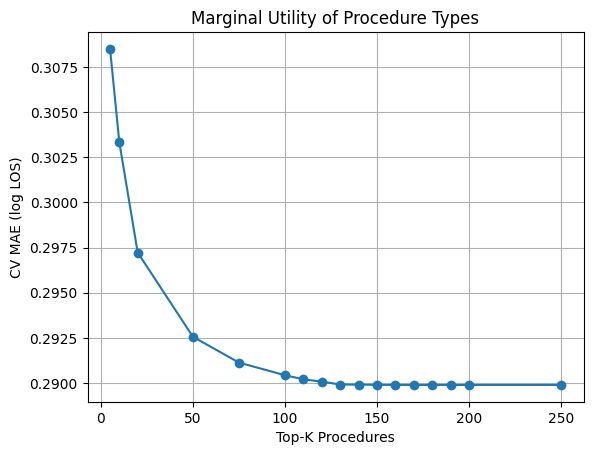

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge


def eval_cv_numeric(X, y, model, n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    maes = []
    for tr, te in kf.split(X):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[te])
        maes.append(mean_absolute_error(y.iloc[te], pred))
    return float(np.mean(maes))

def build_presence(df_events, keep_names):
    d = df_events[df_events["canonical_name"].isin(keep_names)][["stay_id", "canonical_name"]].copy()
    d["present"] = 1
    wide = d.pivot_table(
        index="stay_id",
        columns="canonical_name",
        values="present",
        aggfunc="max",
        fill_value=0
    )
    return wide


df = df.copy()
df["los"] = pd.to_numeric(df["los"], errors="coerce")
df["procedure_time_min"] = pd.to_numeric(df["procedure_time_min"], errors="coerce")

df = df.dropna(subset=["stay_id", "los"])
df["log_los"] = np.log1p(df["los"])

stay_n = df["stay_id"].nunique()

cov = (
    df.groupby("canonical_name")["stay_id"]
      .nunique()
      .sort_values(ascending=False)
)

cov = cov.to_frame("n_stays")
cov["coverage"] = cov["n_stays"] / stay_n

print("Total unique procedures:", len(cov))


summary = (
    df.groupby("stay_id")
      .agg(
          proc_events=("canonical_name", "size"),
          proc_unique=("canonical_name", pd.Series.nunique),
          proc_time_sum=("procedure_time_min", "sum"),
          proc_time_mean=("procedure_time_min", "mean"),
          los=("los", "first"),
          log_los=("log_los", "first"),
      )
)

y = summary["log_los"]


Ks = [5, 10, 20, 50, 75 ,100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 250]
ridge = Ridge(alpha=2.0)

rows = []

for K in Ks:
    topk = cov.head(K).index

    pres = build_presence(df, topk)

    X = summary.merge(pres, left_index=True, right_index=True, how="left")
    X = X.fillna(0)

    X_model = X.drop(columns=["los", "log_los"])

    mae = eval_cv_numeric(X_model, y, ridge)

    rows.append({
        "K": K,
        "n_features": X_model.shape[1],
        "mae_log": mae
    })

    print(f"K={K:<4} | features={X_model.shape[1]:<4} | MAE={mae:.6f}")

res = pd.DataFrame(rows)

plt.figure()
plt.plot(res["K"], res["mae_log"], marker="o")
plt.xlabel("Top-K Procedures")
plt.ylabel("CV MAE (log LOS)")
plt.title("Marginal Utility of Procedure Types")
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

df = procedure.copy()
k = 100

df["canonical_name"] = df["canonical_name"].astype(str)


stay_n = df["stay_id"].nunique()

coverage = (
    df.groupby("canonical_name")["stay_id"]
      .nunique()
      .sort_values(ascending=False)
)

top_k = coverage.head(k).index

print("Selected procedures:", len(top_k))

df_top_k = df[df["canonical_name"].isin(top_k)].copy()

print("Original rows:", len(df))
print("Filtered rows:", len(df_top_k))


print("Unique stays kept:", df_top_k["stay_id"].nunique())
print("Unique procedures kept:", df_top_k["canonical_name"].nunique())

In [ ]:
df_top_k.to_parquet(f'{dir}/{save_file_address}/procedure_top_100.parquet')

### Load Top_100

In [ ]:
procedure = pd.read_parquet(f'{dir}/{save_file_address}/procedure_top_100.parquet')

## Chartevents

#### Text Event

##### Load

In [ ]:
import json

text_chartevents = pd.read_parquet(f'{dir}/{save_file_address}/text_chartevents.parquet')

# df_filtered = pd.read_parquet(f'{dir}/{save_file_address}/text_chartevents_filter.parquet')

# encoded_df = pd.read_parquet(f'{dir}/{save_file_address}/text_chartevents_encoded.parquet')
# strength_df  = pd.read_csv(f'{dir}/{save_file_address}/text_chartevents_strength.csv')

# with open(f'{dir}/{save_file_address}/textchart_concept2id.json', 'r') as f:
#     concept2id = json.dump(f)

# with open(f'{dir}/{save_file_address}/textchart_value2id.json', 'r') as f:
#     value2id = json.load(f)

# with open(f'{dir}/{save_file_address}/textchart_vocab.json', 'r') as f:
#     vocab_serializable = json.load(f)

# print('concept2id, value2id, and vocab saved as JSON files.')

#### Raw Process

In [ ]:
keep_cats = {
    'Respiratory',
    'Hemodynamics',
    'Cardiovascular',
    'Cardiovascular (Pacer Data)',
    'Routine Vital Signs',
    'Dialysis',
    'Neurological',
    'IABP',
    'Pulmonary',

}

df_filtered = text_chartevents[
    text_chartevents['category'].isin(keep_cats)
].copy()

print("Remaining categories:")
print(sorted(df_filtered['category'].unique()))

In [ ]:
import re

def normalize_text(v):
    v = str(v).lower().strip()
    v = re.sub(r"\s+", "", v)
    return v

df_filtered["norm_value"] = df_filtered["value"].map(normalize_text)

In [ ]:
df_filtered['norm_value'].value_counts().to_csv('norm.csv', index = True)

In [ ]:
TIME_MAX_H = 24.0
MIN_STAY_COVERAGE = 0.01
TOPK_PER_LABEL = 30
MIN_VALUE_COUNT = 200
RARE_OTHER_TOKEN = "__OTHER__"
NONE_TOKEN = "__NONE__"
UNKNOWN_TOKEN = "__UNKNOWN__"
NORMAL_TOKEN = "normal"

In [ ]:
def prepare_text_df(text_df: pd.DataFrame) -> pd.DataFrame:
    df = text_df.copy()

    df["norm_value"] = (
        df["norm_value"]
        .astype(str)
        .str.strip()
        .str.lower()
    )

    df.loc[df["norm_value"].isin(["nan", "none", "null", ""]), "norm_value"] = NONE_TOKEN

    df["concept"] = df["category"].astype(str).str.strip() + " | " + df["label"].astype(str).str.strip()
    return df



In [ ]:
def compute_label_strength(df: pd.DataFrame) -> pd.DataFrame:
    n_stays = df["stay_id"].nunique()

    cov = (
        df.groupby("concept")["stay_id"]
        .nunique()
        .rename("stay_coverage")
        .reset_index()
    )
    cov["stay_coverage_pct"] = cov["stay_coverage"] / n_stays

    vc = df.groupby(["concept", "norm_value"]).size().rename("cnt").reset_index()
    vc["p"] = vc.groupby("concept")["cnt"].transform(lambda x: x / x.sum())
    entropy = vc.groupby("concept")["p"].apply(lambda p: -(p * np.log(p + 1e-12)).sum()).rename("value_entropy").reset_index()

    out = cov.merge(entropy, on="concept", how="left")
    return out.sort_values(["stay_coverage_pct", "value_entropy"], ascending=False)


In [ ]:
def build_value_vocab_per_label(df: pd.DataFrame,
                                topk_per_label=TOPK_PER_LABEL,
                                min_value_count=MIN_VALUE_COUNT) -> dict:
    vocab = {}
    for concept, g in df.groupby("concept"):
        counts = g["norm_value"].value_counts()
        keep = counts[counts >= min_value_count].head(topk_per_label).index.tolist()

        special_keep = [NONE_TOKEN]
        if NORMAL_TOKEN in counts.index:
            special_keep.append(NORMAL_TOKEN)

        keep = list(dict.fromkeys(special_keep + keep))
        vocab[concept] = set(keep)
    return vocab


In [ ]:
def apply_vocab(df: pd.DataFrame, vocab: dict) -> pd.DataFrame:
    df = df.copy()
    def map_value(row):
        concept = row["concept"]
        v = row["norm_value"]
        if concept in vocab and v in vocab[concept]:
            return v
        return RARE_OTHER_TOKEN

    df["value_clean"] = df.apply(map_value, axis=1)
    return df

def make_id_maps(df: pd.DataFrame):
    concept_list = df["concept"].unique().tolist()
    value_list = df["value_clean"].unique().tolist()

    concept2id = {c:i for i,c in enumerate(concept_list)}
    value2id = {v:i for i,v in enumerate(value_list)}

    return concept2id, value2id

def encode_df(df: pd.DataFrame, concept2id: dict, value2id: dict) -> pd.DataFrame:
    df = df.copy()
    df["concept_id"] = df["concept"].map(concept2id).astype("int32")
    df["value_id"] = df["value_clean"].map(value2id).astype("int32")
    return df

In [ ]:
def text_chartevents_pipeline(text_df: pd.DataFrame):
    df = prepare_text_df(text_df)

    strength = compute_label_strength(df)
    # فیلتر labelهای قابل نگه‌داشتن (بدون LOS)
    strong_concepts = strength.loc[strength["stay_coverage_pct"] >= MIN_STAY_COVERAGE, "concept"].tolist()
    df = df[df["concept"].isin(strong_concepts)].copy()

    vocab = build_value_vocab_per_label(df)
    df = apply_vocab(df, vocab)

    concept2id, value2id = make_id_maps(df)
    df = encode_df(df, concept2id, value2id)

    return df, strength, vocab, concept2id, value2id

encoded_df, strength_df, vocab, concept2id, value2id = text_chartevents_pipeline(df_filtered)

In [ ]:
import json
df_filtered.to_parquet(f'{dir}/{save_file_address}/text_chartevents_filter.parquet')
encoded_df.to_parquet(f'{dir}/{save_file_address}/text_chartevents_encoded.parquet')
strength_df.to_csv(f'{dir}/{save_file_address}/text_chartevents_strength.csv')

with open(f'{dir}/{save_file_address}/textchart_concept2id.json', 'w') as f:
    json.dump(concept2id, f)

with open(f'{dir}/{save_file_address}/textchart_value2id.json', 'w') as f:
    json.dump(value2id, f)

vocab_serializable = {k: list(v) for k, v in vocab.items()}
with open(f'{dir}/{save_file_address}/textchart_vocab.json', 'w') as f:
    json.dump(vocab_serializable, f)

print('concept2id, value2id, and vocab saved as JSON files.')

In [ ]:
del df, ridge, X_model, X, text_chartevents, icu_stay_selected_score

In [ ]:
del df_top_k, procedure, pres

#### make

In [ ]:
text_chartevents_query = """
WITH selected_category AS (
    SELECT
        d.category,
    FROM `physionet-data.mimiciv_3_1_icu.icustays` i
    JOIN `physionet-data.mimiciv_3_1_icu.chartevents` ce
        ON i.stay_id = ce.stay_id
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
        ON ce.itemid = d.itemid
    GROUP BY d.category
    HAVING count(distinct ce.stay_id) >= 1000
),

selected_items AS (
    SELECT
        d.itemid id,
    FROM `physionet-data.mimiciv_3_1_icu.icustays` i
    JOIN `physionet-data.mimiciv_3_1_icu.chartevents` ce
        ON i.stay_id = ce.stay_id
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
        ON ce.itemid = d.itemid
    GROUP BY d.itemid
    HAVING count(distinct ce.stay_id) >= 750
)



SELECT
ce.subject_id, ce.hadm_id, ce.stay_id,
d.itemid,
DATETIME_DIFF(ce.charttime, i.intime, MINUTE) / 60.0 AS hours_since_icu,
d.label,
d.category,
-- min(i.los) minimum,
-- avg(i.los) mean,
-- max(i.los) maximum,

-- d.unitname, d.param_type,
-- ce.itemid,
ce.value,
-- ce.valuenum,
-- ce.valueuom,
ce.warning

FROM `physionet-data.mimiciv_3_1_icu.chartevents` ce
JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
    ON ce.itemid = d.itemid AND d.param_type = 'Text'
JOIN `physionet-data.mimiciv_3_1_icu.icustays` i
    ON i.stay_id = ce.stay_id

WHERE ce.charttime >= i.intime
    AND (ce.charttime < DATETIME_ADD(i.intime, INTERVAL 24 HOUR)
        OR ce.storetime < DATETIME_ADD(i.intime, INTERVAL 24 HOUR))
    AND category IN (SELECT category FROM selected_category)
    AND d.itemid IN (SELECT id FROM selected_items)
    -- AND d.param_type = 'Text'


"""
process_query_in_chunks(text_chartevents_query, save_file_address, 'text_chartevents', page_size= 1_000_000_000)


#### Numeric chart

##### Load


In [ ]:
# numeric_chart_events = pd.read_parquet(f'{dir}/{save_file_address}/numeric_chartevents.parquet')
numeric_chart_events = pd.read_parquet(f'{dir}/{save_file_address}/numeric_chartevents_filtered.parquet')

##### Raw Preprocess


In [ ]:
keep_cats = {
    'Respiratory',
    'Hemodynamics',
    'Cardiovascular',
    'Cardiovascular (Pacer Data)',
    'Routine Vital Signs',
    'Dialysis',
    'Neurological',
    'IABP',
    'Pulmonary',

}

df_filtered = numeric_chart_events[
    numeric_chart_events['category'].isin(keep_cats)
].copy()

print("Remaining categories:")
print(sorted(df_filtered['category'].unique()))

Remaining categories:
['Cardiovascular (Pacer Data)', 'Dialysis', 'Hemodynamics', 'IABP', 'Respiratory', 'Routine Vital Signs']


In [ ]:
df_filtered.to_parquet(f'{dir}/{save_file_address}/numeric_chartevents_filtered.parquet')

In [ ]:
del df_filtered

##### Make

In [ ]:
numeric_chart_events = """
WITH selected_category AS (
    SELECT
        d.category,
    FROM `physionet-data.mimiciv_3_1_icu.icustays` i
    JOIN `physionet-data.mimiciv_3_1_icu.chartevents` ce
        ON i.stay_id = ce.stay_id
     JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
        ON ce.itemid = d.itemid
    GROUP BY d.category
    HAVING count(distinct ce.stay_id) >= 1000
),

selected_items AS (
    SELECT
        d.itemid id,
    FROM `physionet-data.mimiciv_3_1_icu.icustays` i
    JOIN `physionet-data.mimiciv_3_1_icu.chartevents` ce
        ON i.stay_id = ce.stay_id
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
        ON ce.itemid = d.itemid
    GROUP BY d.itemid
    HAVING count(distinct ce.stay_id) >= 750
)



SELECT
ce.subject_id,
ce.hadm_id,
ce.stay_id,
d.itemid,
DATETIME_DIFF(ce.charttime, i.intime, MINUTE) / 60.0 AS hours_since_icu,

d.label,
d.category,
-- min(i.los) minimum,
-- avg(i.los) mean,
-- max(i.los) maximum,

-- d.unitname, d.param_type,
-- ce.itemid,
ce.value,
ce.valuenum,
ce.valueuom,
-- warning

FROM `physionet-data.mimiciv_3_1_icu.chartevents` ce
JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
    ON ce.itemid = d.itemid AND d.param_type != 'Text' AND d.param_type != 'Checkbox'
JOIN `physionet-data.mimiciv_3_1_icu.icustays` i
    ON i.stay_id = ce.stay_id

WHERE ce.charttime >= i.intime
    AND (ce.charttime < DATETIME_ADD(i.intime, INTERVAL 24 HOUR)
        OR ce.storetime < DATETIME_ADD(i.intime, INTERVAL 24 HOUR))
    AND category IN (SELECT category FROM selected_category)
    AND d.itemid IN (SELECT id FROM selected_items)
    AND  d.param_type != 'Text' AND d.param_type != 'Checkbox'


"""

process_query_in_chunks(numeric_chart_events, save_file_address, 'numeric_chartevents', page_size= 100_000_000)

Processing chunk 0...
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Processing chunk 36...
Processing chunk 37...
Processing chunk 38...
Processing chunk 39...
Processing chunk 40...
Processing chunk 41...
Processing chunk 42...
Processing chunk 43..

### Check Box

#### Load

In [ ]:
check_box_chartevents = pd.read_parquet(f'{dir}/{save_file_address}/check_box_chartevents.parquet')
# check_box_chartevents_filtered = pd.read_parquet(f'{dir}/{save_file_address}/check_box_chartevents_filtered.parquet')

#### Raw Preprocess


In [ ]:
drop_categories = {
    'Adm History/FHPA',
    'Alarms',
    'Restraint/Support Systems',
    'Skin - Impairment'
}

check_box_chartevents_filtered = check_box_chartevents[~check_box_chartevents['category'].isin(drop_categories)]

drop_label_keywords = [
    'consent',
    'guardian',
    'checklist',
    'fear',
    'recreational',
    'etoh',
    'social work',
    'discharge'
]

mask = check_box_chartevents_filtered['label'].str.lower().str.contains('|'.join(drop_label_keywords))
check_box_chartevents_filtered = check_box_chartevents_filtered[~mask]


min_prevalence = 0.01

prev = (
    check_box_chartevents_filtered.groupby('label')['stay_id']
      .nunique()
      .div(check_box_chartevents_filtered['stay_id'].nunique())
)
keep_labels = prev[prev >= min_prevalence].index
df = check_box_chartevents_filtered[check_box_chartevents_filtered['label'].isin(keep_labels)]

In [ ]:
iv_labels = check_box_chartevents_filtered['label'].str.contains('gauge', case=False, regex=True)

In [ ]:
check_box_chartevents_filtered[check_box_chartevents_filtered['label'].isin(prev[prev >= min_prevalence].index)]

In [ ]:
check_box_chartevents_filtered.to_parquet(f'{dir}/{save_file_address}/check_box_chartevents_filtered.parquet')

In [ ]:
del check_box_chartevents

#### Make


In [ ]:
check_box_chart_events = """
WITH selected_category AS (
    SELECT
        d.category,
    FROM `physionet-data.mimiciv_3_1_icu.icustays` i
    JOIN `physionet-data.mimiciv_3_1_icu.chartevents` ce
        ON i.stay_id = ce.stay_id
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
        ON ce.itemid = d.itemid
    GROUP BY d.category
    HAVING count(distinct ce.stay_id) >= 1000
),

selected_items AS (
    SELECT
        d.itemid id,
    FROM `physionet-data.mimiciv_3_1_icu.icustays` i
    JOIN `physionet-data.mimiciv_3_1_icu.chartevents` ce
        ON i.stay_id = ce.stay_id
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
        ON ce.itemid = d.itemid
    GROUP BY d.itemid
    HAVING count(distinct ce.stay_id) >= 750
)

SELECT
ce.subject_id, ce.hadm_id, ce.stay_id,
d.itemid,
DATETIME_DIFF(ce.charttime, i.intime, MINUTE) / 60.0 AS hours_since_icu,

d.label,
d.category,
-- min(i.los) minimum,
-- avg(i.los) mean,
-- max(i.los) maximum,

-- d.unitname,
-- d.param_type,

-- ce.itemid,
ce.value,
-- ce.valuenum,
-- ce.valueuom,
-- ce.warning

FROM `physionet-data.mimiciv_3_1_icu.chartevents` ce
JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
    ON ce.itemid = d.itemid AND d.param_type = 'Checkbox'
JOIN `physionet-data.mimiciv_3_1_icu.icustays` i
    ON i.stay_id = ce.stay_id

WHERE ce.charttime >= i.intime
    AND (ce.charttime < DATETIME_ADD(i.intime, INTERVAL 24 HOUR)
        OR ce.storetime < DATETIME_ADD(i.intime, INTERVAL 24 HOUR))
    AND category IN (SELECT category FROM selected_category)
    AND d.itemid IN (SELECT id FROM selected_items)
    AND d.param_type = 'Checkbox'
    -- AND category = 'General'
    """

process_query_in_chunks(check_box_chart_events, save_file_address, 'check_box_chartevents', page_size= 100_000_000)

## Input Events

### Load

In [ ]:
input_events = pd.read_parquet(f'{dir}/{save_file_address}/input_events.parquet')
input_events.drop(columns = ['secondaryordercategoryname']).to_parquet('input.parquet')

### Make

In [ ]:
input_events_query = """
SELECT
i.subject_id, i.hadm_id, i.stay_id,
 d.itemid,
 d.label,
-- starttime, endtime,
    DATETIME_DIFF(ie.starttime, i.intime, MINUTE) / 60.0 AS hours_since_icu,
amount,
amountuom,
rate,
rateuom,
ordercategoryname, secondaryordercategoryname, patientweight,
statusdescription
FROM `physionet-data.mimiciv_3_1_icu.inputevents` ie
JOIN `physionet-data.mimiciv_3_1_icu.icustays` i
  ON ie.stay_id = i.stay_id
JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
  ON ie.itemid = d.itemid
WHERE ie.starttime >= i.intime
  AND ie.starttime < DATETIME_ADD(i.intime, INTERVAL 24 HOUR)
  """

process_query_in_chunks(input_events_query, save_file_address, 'input_events', page_size= 100_000_000)

## Output Events

### Load

In [ ]:
output_events = pd.read_parquet(f'{dir}/{save_file_address}/output_events.parquet')

### Make

In [ ]:
output_events_query = """
SELECT
i.subject_id, i.hadm_id, i.stay_id,
 d.itemid,
  TRIM(REGEXP_REPLACE(d.label, r'\s*#\d+', '')) AS label,
  COALESCE(SAFE_CAST(REGEXP_EXTRACT(d.label, r'#(\d+)') AS INT64), 0) AS part,
  SAFE_CAST(REGEXP_CONTAINS(d.label, r'#\d+') AS INT64) AS has_part,
-- starttime, endtime,
    DATETIME_DIFF(oe.charttime, i.intime, MINUTE) / 60.0 AS hours_since_icu,
value,
valueuom,
abbreviation
FROM `physionet-data.mimiciv_3_1_icu.icustays` i
JOIN `physionet-data.mimiciv_3_1_icu.outputevents` oe

  ON oe.stay_id = i.stay_id
JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
  ON oe.itemid = d.itemid
WHERE oe.charttime >= i.intime
  AND oe.charttime < DATETIME_ADD(i.intime, INTERVAL 24 HOUR)
  AND d.label NOT IN ('Void', 'Pre-Admission')

  """
process_query_in_chunks(output_events_query, save_file_address, 'output_events', page_size= 100_000_000)

## Datetime Event

### Load


In [ ]:
datetime_event = pd.read_parquet(f'{dir}/{save_file_address}/datetime_event.parquet')
# dateevents_temporal_representations = np.loadz(f'{dir}/{save_file_address}/dateevents_temporal_representations.npz')

#### Raw Processs

In [ ]:
import re
import pandas as pd

# -----------------------------
# 1) Normalization
# -----------------------------
def normalize_label(label: str) -> str:
    if pd.isna(label):
        return ""
    l = str(label).strip().lower()

    # unify whitespace
    l = re.sub(r"\s+", " ", l)

    # common typos / formatting glitches
    l = l.replace("indentified", "identified")
    l = l.replace("cathetertubing", "catheter tubing")
    l = l.replace("portacath", "porta cath")

    # unify d/c and de-access
    l = l.replace("d/c", "dc")
    l = l.replace("de-accessed", "deaccessed")
    l = l.replace("de accessed", "deaccessed")

    # normalize punctuation spacing
    l = re.sub(r"\s*-\s*", " - ", l)
    l = re.sub(r"\s*#\s*", " #", l)

    return l


# -----------------------------
# 2) Action extraction (rule-based)
# -----------------------------
def extract_action(label_norm: str) -> str:
    l = label_norm

    # high-signal actions
    if "insertion date" in l:
        return "insertion"
    if "change over wire" in l:
        return "wire_change"
    if "dressing change" in l:
        return "dressing_change"
    if "cap change" in l:
        return "cap_change"
    if "tubing change" in l:
        return "tubing_change"
    if "calibrated" in l or "zero/calibrate" in l or "zero / calibrate" in l:
        return "calibration"
    if "date identified" in l:
        return "identified_date"

    # likely leakage-ish / discharge-ish actions
    if "removal date" in l:
        return "removal"
    if " dc date" in f" {l}" or l.endswith(" dc date"):
        return "dc"
    if "deaccessed" in l or "date deaccessed" in l:
        return "deaccess"

    # misc admin/time fields
    if l in {"time completed", "time of initiation"} or l.startswith("time "):
        return "time_marker"
    if l.startswith("date - "):
        return "staff_date"
    if "referral date" in l:
        return "referral"

    # personal/non-icu
    if "last menses" in l:
        return "last_menses"
    if "pregnancy due date" in l:
        return "pregnancy_due"

    return "other"


# -----------------------------
# 3) Device/entity extraction (rule-based)
# -----------------------------
DEVICE_PATTERNS = [
    ("dialysis_catheter", [r"\bdialysis catheter\b"]),
    ("impella", [r"\bimpella\b"]),
    ("iabp", [r"\biabp\b"]),
    ("icp_line", [r"\bicp line\b"]),
    ("arterial_line", [r"\barterial line\b", r"\barterial line\b"]),
    ("picc", [r"\bpicc\b"]),
    ("midline", [r"\bmidline\b"]),
    ("sheath", [r"\bsheath\b"]),
    ("pa_catheter", [r"\bpa catheter\b"]),
    ("cco_pac", [r"\bcco pac\b"]),
    ("presep", [r"\bpresep\b", r"\bscvo2\b", r"\bsvo2\b"]),
    ("foley", [r"\bfoley\b"]),
    ("gu_catheter", [r"\bgu catheter\b"]),
    ("cordis", [r"\bcordis\b", r"\bintroducer\b", r"\btriple introducer\b", r"\bmulti lumen\b"]),
    ("tunneled_hickman", [r"\bhickman\b", r"\btunneled\b"]),
    ("ava", [r"\bava\b", r"\bavalon\b"]),
    ("pheresis_catheter", [r"\bpheresis catheter\b"]),
    ("trauma_line", [r"\btrauma line\b"]),
    ("ekos", [r"\bekos\b"]),
    ("pressure_ulcer", [r"\bpressure ulcer\b"]),
    ("impaired_skin", [r"\bimpaired skin\b"]),
    ("tandem_heart", [r"\btandem heart\b", r"\bcardiac assist cannula\b", r"\bcannula\b"]),
    ("io", [r"\bio insertion\b", r"\bio\b"]),
    ("ric", [r"\bric\b"]),
    ("indwelling_port", [r"\bporta cath\b", r"\bindwelling\b", r"\bport #\b"]),
]

def extract_device(label_norm: str) -> str:
    l = label_norm
    for dev, pats in DEVICE_PATTERNS:
        for p in pats:
            if re.search(p, l):
                return dev
    return "other"


# -----------------------------
# 4) Cleaning + filtering pipeline
# -----------------------------
def clean_dateevents(
    dateevents: pd.DataFrame,
    time_col: str = "charttime_hours_since_icu",
    window_hours: float = 48.0,
    min_prevalence: float = 0.001,   # 0.1% of stays
    drop_leakage_actions: bool = True
) -> pd.DataFrame:
    df = dateevents.copy()

    # enforce required cols
    required = {"stay_id", "label"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # normalize + parse
    df["label_norm"] = df["label"].apply(normalize_label)
    df["action"] = df["label_norm"].apply(extract_action)
    df["device"] = df["label_norm"].apply(extract_device)

    # time window filter (prevents obvious leakage)
    if time_col in df.columns:
        df = df[df[time_col].between(0, window_hours, inclusive="both")].copy()

    # drop obvious junk/admin/personal fields
    drop_actions_base = {
        "time_marker", "staff_date", "referral",
        "last_menses", "pregnancy_due"
    }
    df = df[~df["action"].isin(drop_actions_base)].copy()

    # optional: drop high-risk discharge-ish actions even without LOS
    if drop_leakage_actions:
        risky = {"removal", "dc", "deaccess"}
        df = df[~df["action"].isin(risky)].copy()

    # build a compact "clean label"
    df["label_clean"] = df["device"] + "__" + df["action"]

    # prevalence pruning by stay-level occurrence
    # prevalence = (#stays that have at least one occurrence of label_clean) / (#stays total)
    total_stays = df["stay_id"].nunique()
    if total_stays == 0:
        return df

    stay_has_label = df.groupby(["label_clean"])["stay_id"].nunique()
    prevalence = stay_has_label / total_stays
    keep_labels = prevalence[prevalence >= min_prevalence].index

    df = df[df["label_clean"].isin(keep_labels)].copy()

    return df


# -----------------------------
# 5) Optional: build hourly features (event counts per hour)
# -----------------------------
def build_hourly_event_features(
    df_clean: pd.DataFrame,
    time_col: str = "charttime_hours_since_icu",
    window_hours: int = 24
) -> pd.DataFrame:
    """
    Returns long-format features:
      stay_id, hour, label_clean, value(count)
    You can pivot later to wide.
    """
    if time_col not in df_clean.columns:
        raise ValueError(f"Column {time_col} not found. Provide a time column in hours.")
    out = df_clean.copy()
    out["hour"] = out[time_col].astype(float).floordiv(1).astype(int)
    out = out[(out["hour"] >= 0) & (out["hour"] < window_hours)]

    feat = (
        out.groupby(["stay_id", "hour", "label_clean"])
           .size()
           .reset_index(name="count")
    )
    return feat


# -----------------------------
# Example usage
# -----------------------------
# 1) Clean
df_clean = clean_dateevents(
    datetime_event,
    time_col="charttime_hours_since_icu",
    window_hours=24,
    min_prevalence=0.001,      # adjust: 0.0005 / 0.002 بسته به اندازه cohort
    drop_leakage_actions=True
)

# 2) Hourly long features (counts)
hourly_long = build_hourly_event_features(
    df_clean,
    time_col="charttime_hours_since_icu",
    window_hours=24
)

# 3) If you need wide matrix per (stay_id, hour):
# hourly_wide = hourly_long.pivot_table(
#     index=["stay_id", "hour"],
#     columns="label_clean",
#     values="count",
#     fill_value=0
# ).reset_index()

In [ ]:
import numpy as np
import pandas as pd

time_col = "charttime_hours_since_icu"
stay_col = "stay_id"

def _make_full_hour_index(stays_ref, T):
    return pd.MultiIndex.from_product(
        [pd.Index(stays_ref, name=stay_col), range(T)],
        names=[stay_col, "hour"]
    )

def prepare_dateevents_for_temporal(df_clean: pd.DataFrame, T: int):
    df = df_clean.copy()
    if time_col not in df.columns:
        raise ValueError(f"Missing {time_col}. Need hours since ICU.")
    df["hour"] = df[time_col].astype(float).floordiv(1).astype(int)
    df = df[(df["hour"] >= 0) & (df["hour"] < T)].copy()
    return df

def build_hourly_label_count_tensor(df, stays_ref, T):
    g = (df.groupby([stay_col, "hour", "label_clean"])
           .size().reset_index(name="count"))

    pivot = g.pivot_table(
        index=[stay_col, "hour"],
        columns="label_clean",
        values="count",
        fill_value=0
    )

    pivot = pivot.reindex(_make_full_hour_index(stays_ref, T), fill_value=0)

    feature_names = list(pivot.columns)
    X = pivot.values.reshape(len(stays_ref), T, len(feature_names)).astype(np.float32)
    return X, feature_names

def build_hourly_label_binary_and_cum_tensor(df, stays_ref, T):
    g = (df.groupby([stay_col, "hour", "label_clean"])
           .size().reset_index(name="count"))
    g["bin"] = 1

    pivot_bin = g.pivot_table(
        index=[stay_col, "hour"],
        columns="label_clean",
        values="bin",
        fill_value=0
    )

    pivot_bin = pivot_bin.reindex(_make_full_hour_index(stays_ref, T), fill_value=0)
    pivot_cum = pivot_bin.groupby(level=0).cumsum()

    feat = list(pivot_bin.columns)
    X_bin = pivot_bin.values.reshape(len(stays_ref), T, len(feat)).astype(np.float32)
    X_cum = pivot_cum.values.reshape(len(stays_ref), T, len(feat)).astype(np.float32)
    return X_bin, X_cum, feat

def build_semantic_agg_tensors(df, stays_ref, T):
    out = {}
    full_index = _make_full_hour_index(stays_ref, T)

    # action counts
    g_act = (df.groupby([stay_col, "hour", "action"])
               .size().reset_index(name="count"))
    pivot_act = g_act.pivot_table(
        index=[stay_col, "hour"], columns="action", values="count", fill_value=0
    ).reindex(full_index, fill_value=0)
    pivot_act_cum = pivot_act.groupby(level=0).cumsum()

    out["X_action_count"] = pivot_act.values.reshape(len(stays_ref), T, pivot_act.shape[1]).astype(np.float32)
    out["X_action_cum"]   = pivot_act_cum.values.reshape(len(stays_ref), T, pivot_act.shape[1]).astype(np.float32)
    out["action_features"] = list(pivot_act.columns)

    # device counts
    g_dev = (df.groupby([stay_col, "hour", "device"])
               .size().reset_index(name="count"))
    pivot_dev = g_dev.pivot_table(
        index=[stay_col, "hour"], columns="device", values="count", fill_value=0
    ).reindex(full_index, fill_value=0)
    pivot_dev_cum = pivot_dev.groupby(level=0).cumsum()

    out["X_device_count"] = pivot_dev.values.reshape(len(stays_ref), T, pivot_dev.shape[1]).astype(np.float32)
    out["X_device_cum"]   = pivot_dev_cum.values.reshape(len(stays_ref), T, pivot_dev.shape[1]).astype(np.float32)
    out["device_features"] = list(pivot_dev.columns)

    # device+action (optional)
    df2 = df.copy()
    df2["dev_act"] = df2["device"].astype(str) + "__" + df2["action"].astype(str)

    g_da = (df2.groupby([stay_col, "hour", "dev_act"])
              .size().reset_index(name="count"))
    pivot_da = g_da.pivot_table(
        index=[stay_col, "hour"], columns="dev_act", values="count", fill_value=0
    ).reindex(full_index, fill_value=0)
    pivot_da_cum = pivot_da.groupby(level=0).cumsum()

    out["X_devact_count"] = pivot_da.values.reshape(len(stays_ref), T, pivot_da.shape[1]).astype(np.float32)
    out["X_devact_cum"]   = pivot_da_cum.values.reshape(len(stays_ref), T, pivot_da.shape[1]).astype(np.float32)
    out["devact_features"] = list(pivot_da.columns)

    return out

def build_dateevents_temporal_representations(df_clean, T=24, stays_ref=None):
    if stays_ref is None:
        stays_ref = pd.Index(df_clean[stay_col].unique(), name=stay_col)

    df = prepare_dateevents_for_temporal(df_clean, T=T)

    sem = build_semantic_agg_tensors(df, stays_ref, T=T)
    X_count, label_feats = build_hourly_label_count_tensor(df, stays_ref, T=T)
    X_bin, X_cum, label_feats2 = build_hourly_label_binary_and_cum_tensor(df, stays_ref, T=T)

    return {
        "stays": stays_ref.to_numpy(),
        **sem,
        "X_label_count": X_count,
        "X_label_bin": X_bin,
        "X_label_cum": X_cum,
        "label_features": label_feats,
    }

rep = build_dateevents_temporal_representations(df_clean, T=24, stays_ref= cohort_stay_ids)

print("stays:", rep["stays"].shape)
print("X_action_cum:", rep["X_action_cum"].shape, "d=", len(rep["action_features"]))
print("X_device_cum:", rep["X_device_cum"].shape, "d=", len(rep["device_features"]))
print("X_devact_cum:", rep["X_devact_cum"].shape, "d=", len(rep["devact_features"]))
print("X_label_cum:", rep["X_label_cum"].shape, "d=", len(rep["label_features"]))

stays: (93995,)
X_action_cum: (93995, 24, 8) d= 8
X_device_cum: (93995, 24, 24) d= 24
X_devact_cum: (93995, 24, 81) d= 81
X_label_cum: (93995, 24, 81) d= 81


In [ ]:
np.savez(f'{dir}/{save_file_address}/dateevents_temporal_representations.npz', **rep)

### Make

In [ ]:
datetime_event_query = """
SELECT
i.subject_id,
i.hadm_id,
i.stay_id,
d.itemid,
d.label,
i.intime,
de.charttime,
DATETIME_DIFF(de.charttime, i.intime, MINUTE) / 60.0 AS charttime_hours_since_icu,

FROM `physionet-data.mimiciv_3_1_icu.icustays` i
JOIN `physionet-data.mimiciv_3_1_icu.datetimeevents` de
    ON i.stay_id = de.stay_id

JOIN `physionet-data.mimiciv_3_1_icu.d_items` d
    ON de.itemid = d.itemid


WHERE de.charttime >= i.intime
    AND de.charttime < DATETIME_ADD(i.intime, INTERVAL 24 HOUR)

"""

process_query_in_chunks(datetime_event_query, save_file_address, 'datetime_event', page_size= 100_000_000)

## Flat Features

In [ ]:
flat_features_sql = """
WITH
extra_vars AS (
  SELECT
    ch.stay_id,
    AVG(IF(d.label = 'Admission Weight (Kg)' AND ch.valuenum != 0, ch.valuenum, NULL)) AS weight,
    AVG(IF(d.label = 'GCS - Eye Opening'     AND ch.valuenum != 0, ch.valuenum, NULL)) AS eyes,
    AVG(IF(d.label = 'GCS - Motor Response'  AND ch.valuenum != 0, ch.valuenum, NULL)) AS motor,
    AVG(IF(d.label = 'GCS - Verbal Response' AND ch.valuenum != 0, ch.valuenum, NULL)) AS verbal,
    AVG(IF(d.label = 'Height (cm)'           AND ch.valuenum != 0, ch.valuenum, NULL)) AS height
  FROM `physionet-data.mimiciv_3_1_icu.chartevents` AS ch
  JOIN `physionet-data.mimiciv_3_1_icu.icustays`    AS i
    ON ch.stay_id = i.stay_id
  JOIN `physionet-data.mimiciv_3_1_icu.d_items`     AS d
    ON d.itemid = ch.itemid
  WHERE ch.valuenum IS NOT NULL
    AND d.label IN (
      'Admission Weight (Kg)',
      'GCS - Eye Opening',
      'GCS - Motor Response',
      'GCS - Verbal Response',
      'Height (cm)'
    )
    AND TIMESTAMP_DIFF(TIMESTAMP(ch.charttime), TIMESTAMP(i.intime), HOUR) BETWEEN -24 AND 5
  GROUP BY ch.stay_id
),

ld_labels AS (
  SELECT
    i.subject_id,
    i.hadm_id,
    i.stay_id,
    i.intime,
    i.outtime,
    adm.hospital_expire_flag,
    i.los
  FROM `physionet-data.mimiciv_3_1_icu.icustays`     AS i
  JOIN `physionet-data.mimiciv_3_1_hosp.admissions` AS adm
    ON adm.hadm_id = i.hadm_id
  JOIN `physionet-data.mimiciv_3_1_hosp.patients`   AS p
    ON p.subject_id = i.subject_id
  WHERE i.los > (5/24)  -- > 5 hours
    AND (EXTRACT(YEAR FROM i.intime) - p.anchor_year + p.anchor_age) > 17
)

SELECT DISTINCT
  la.stay_id AS patientunitstayid,
  p.gender,
  (EXTRACT(YEAR FROM la.intime) - p.anchor_year + p.anchor_age) AS age,
  adm.race AS ethnicity,
  i.first_careunit,
  adm.admission_location,
  adm.insurance,
  ev.height,
  ev.weight,
  EXTRACT(HOUR FROM la.intime) AS hour,
  ev.eyes,
  ev.motor,
  ev.verbal
FROM ld_labels AS la
JOIN `physionet-data.mimiciv_3_1_hosp.patients`       AS p
  ON p.subject_id = la.subject_id
JOIN `physionet-data.mimiciv_3_1_icu.icustays`        AS i
  ON i.stay_id = la.stay_id
JOIN `physionet-data.mimiciv_3_1_hosp.admissions`     AS adm
  ON adm.hadm_id = la.hadm_id
LEFT JOIN extra_vars AS ev
  ON ev.stay_id = la.stay_id
;
"""

process_query_in_chunks(flat_features_sql, save_file_address, 'flat_features')

# Node Embedding Preprocess


## Functions

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np


import torch
from torch_geometric.data import HeteroData
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict

import gc
import os
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/Thesis/Codes/Data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir = '/content/drive/MyDrive/Thesis/Codes/Data'
save_file_address = f'Graph_v2_1'
data = torch.load(f'{dir}/{save_file_address}/data_chart.pt', weights_only=False)

# icu_stay_details = icu_stay_details[icu_stay_details['stay_id'].isin(data['stay'].ids)]
# stay_id_map = build_id_map(data['stay'].ids)

In [ ]:
def build_id_map(unique_vals):
    return {val: i for i, val in enumerate(unique_vals)}

def check_columns(cols_to_check, df, ind):
  node_candidates = []
  edge_candidates = []

  for col in cols_to_check:
      uniq_counts = df.groupby(ind)[col].nunique()

      if (uniq_counts <= 1).all():
          node_candidates.append(col)
      else:
          edge_candidates.append(col)

  print(f"Likely NODE features (constant for each {ind}):", node_candidates)
  print("Likely EDGE features (vary across stays):", edge_candidates)

  return node_candidates, edge_candidates

def bool_to_int(df):
  for col in df.columns:
      if df[col].dtype == bool:
        df[col] = df[col].astype(int)

  return df

stay_id_map = build_id_map(data['stay'].ids)

In [ ]:
def build_pretrained_embeddings(
    df: pd.DataFrame,
    text_col: str = "Building",
    node_id_col: str = "diag_node_id",
    model_name: str = "emilyalsentzer/Bio_ClinicalBERT",
    batch_size: int = 32,
    max_length: int = 128,
    device: str = None,
    projection_dim: int = 64):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    projection_layer = nn.Linear(model.config.hidden_size, projection_dim).to(device)


    unique_df = df[[node_id_col, text_col]].drop_duplicates().reset_index(drop=True)

    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(unique_df), batch_size), desc=f"Embedding {text_col}"):
            batch_texts = unique_df[text_col].iloc[i:i+batch_size].astype(str).tolist()

            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length
            ).to(device)

            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            projected_embeddings = projection_layer(cls_embeddings).cpu().numpy()
            embeddings.append(projected_embeddings)

    embeddings = np.vstack(embeddings)

    final_embeddings = dict(zip(unique_df[node_id_col], embeddings))

    return final_embeddings

In [ ]:
import re
from collections import defaultdict

def make_feature_name(feature_names):
  group_indices = defaultdict(list)

  for idx, feat in enumerate(feature_names):
      base = re.split(r"_emb\d+|_ont\d+|_\d+$", feat)[0]
      group_indices[base].append(idx)

  feature_ranges = {k: [v[0], v[-1]] for k, v in group_indices.items()}

  # print(feature_ranges)
  return feature_ranges

## Stays Node

In [ ]:
# icu_stay_details = icu_stay_details[(icu_stay_details['los']<=60) & (icu_stay_details['los'] >= 5/24)]
icu_stay_details = bool_to_int(icu_stay_details)
stay_id_map = build_id_map(icu_stay_details['stay_id'].unique())

In [ ]:
import json

stay_id_map_serializable = {str(int(k)): v for k, v in stay_id_map.items()}

with open(f'{dir}/stay_id_map.json', 'w') as f:
    json.dump(stay_id_map_serializable, f)

### Categorical One Hotted

In [ ]:
unit_map = {
    # Medical / Mixed ICU
    "Medical Intensive Care Unit (MICU)": "Medical / Mixed ICU",
    "Medical/Surgical Intensive Care Unit (MICU/SICU)": "Medical / Mixed ICU",
    "Intensive Care Unit (ICU)": "Medical / Mixed ICU",

    # Surgical / Trauma ICU
    "Surgical Intensive Care Unit (SICU)": "Surgical / Trauma ICU",
    "Trauma SICU (TSICU)": "Surgical / Trauma ICU",
    "Surgery/Trauma": "Surgical / Trauma ICU",

    # Cardiac ICU
    "Cardiac Vascular Intensive Care Unit (CVICU)": "Cardiac ICU",
    "Coronary Care Unit (CCU)": "Cardiac ICU",
    "Medicine/Cardiology Intermediate": "Cardiac ICU",

    # Neuro Critical Care
    "Neuro Surgical Intensive Care Unit (Neuro SICU)": "Neuro Critical Care",
    "Neuro Intermediate": "Neuro Critical Care",
    "Neuro Stepdown": "Neuro Critical Care",

    # Intermediate / Recovery Units
    "Surgery/Vascular/Intermediate": "Intermediate / Recovery Units",
    "PACU": "Intermediate / Recovery Units",
    "Medicine": "Intermediate / Recovery Units",
    "Med/Surg": "Intermediate / Recovery Units"
}
icu_stay_details['icu_careunit'] = icu_stay_details['icu_careunit'].map(unit_map)


admission_type_map = {
    "EW EMER.": "Emergency",
    "DIRECT EMER.": "Emergency",
    "URGENT": "Urgent",
    "OBSERVATION ADMIT": "Observation",
    "EU OBSERVATION": "Observation",
    "DIRECT OBSERVATION": "Observation",
    "AMBULATORY OBSERVATION": "Observation",
    "ELECTIVE": "Elective",
    "SURGICAL SAME DAY ADMISSION": "Surgical / Planned Procedure"
}
icu_stay_details["hosp_admission_type"] = icu_stay_details["hosp_admission_type"].map(admission_type_map).fillna("Other")


admission_location_map = {
    # Emergency origin
    "EMERGENCY ROOM": "Emergency Department",

    # Transfers (external institutions)
    "TRANSFER FROM HOSPITAL": "External Transfer",
    "TRANSFER FROM SKILLED NURSING FACILITY": "External Transfer",
    "AMBULATORY SURGERY TRANSFER": "External Transfer",

    # Referral sources
    "PHYSICIAN REFERRAL": "Referral",
    "CLINIC REFERRAL": "Referral",

    # Self-presented
    "WALK-IN/SELF REFERRAL": "Self / Walk-in",

    # Procedural / Perioperative
    "PROCEDURE SITE": "Procedure / Perioperative",
    "PACU": "Procedure / Perioperative",

    # Special / Administrative
    "INTERNAL TRANSFER TO OR FROM PSYCH": "Internal Transfer",
    "INFORMATION NOT AVAILABLE": "Unknown"
}
icu_stay_details["hosp_admission_location"] = icu_stay_details["hosp_admission_location"].map(admission_location_map).fillna("Other")



In [ ]:
cat_cols = [
    'icu_careunit',
    'hosp_admission_type',
    'hosp_admission_location'
]

icu_stay_details = pd.get_dummies(
    icu_stay_details,
    columns=cat_cols,
    prefix=cat_cols,
    drop_first=False
)

In [ ]:
icu_stay_details = bool_to_int(icu_stay_details)

### Normilize


In [ ]:
should_normalize = []
for col in icu_stay_details.columns:
  if icu_stay_details[col].nunique() >= 3 and not col.endswith('_id')  and col != 'los':
    should_normalize.append(col)

In [ ]:
for col in should_normalize:
  input_tensor = torch.tensor(icu_stay_details[col].values, dtype=torch.float32).unsqueeze(0)
  normalized_tensor = nn.functional.layer_norm(input_tensor, (1, len(icu_stay_details)))
  icu_stay_details[f'{col}'] = normalized_tensor.squeeze(0).numpy()

In [ ]:
icu_stay_details.to_parquet(f'{dir}/{save_file_address}/Nodes/stay_nodes.parquet')


stay_id_map_serializable = {str(int(k)): v for k, v in stay_id_map.items()}

with open(f'{dir}/{save_file_address}/stay_id_map.json', 'w') as f:
    json.dump(stay_id_map_serializable, f)

In [ ]:
icu_stay_details = pd.read_parquet(f'{dir}/{save_file_address}/Nodes/stay_nodes.parquet')


stay_id_map_serializable = {str(int(k)): v for k, v in stay_id_map.items()}

with open(f'{dir}/{save_file_address}/stay_id_map.json', 'w') as f:
    json.dump(stay_id_map_serializable, f)

## Patient

In [ ]:
patient = pd.read_parquet(f'{dir}/{save_file_address}/patient.parquet')
patient['gender'] = patient['gender'].map({'F': 1, 'M':0})
patient_id_map = build_id_map(patient['subject_id'].unique())

In [ ]:
patient = bool_to_int(patient)

In [ ]:
should_normalize=['anchor_age', 'age_score',  'charlson_comorbidity_index']
for col in should_normalize:
  input_tensor = torch.tensor(patient[col].values, dtype=torch.float32).unsqueeze(0)
  normalized_tensor = nn.functional.layer_norm(input_tensor, (1, len(patient)))
  patient[f'{col}'] = normalized_tensor.squeeze(0).numpy()

In [ ]:
src =  torch.tensor([patient_id_map[pid] for pid in icu_stay_details['subject_id']], dtype=torch.long)
dst =  torch.tensor([stay_id_map[sid] for sid in icu_stay_details['stay_id']], dtype=torch.long)

edge_index = torch.stack([src, dst])

,subject_id,hadm_id,gender,anchor_age,age_score,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,...,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index
0,10000032,29079034,1,-0.179139,-0.309858,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0.519230
1,10000068,25022803,1,-1.809968,-1.006849,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.033087
2,10000084,29888819,0,0.809243,1.084124,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.208766
3,10000108,27250926,0,-1.513454,-1.006849,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.033087
4,10000117,27988844,1,-0.376815,-1.006849,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.033087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223447,19999733,27674281,1,-1.809968,-1.006849,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.033087
223448,19999784,29956342,0,0.067957,-0.309858,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,0.519230
223449,19999828,29734428,1,-0.475653,-1.006849,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,-0.412160
223450,19999840,26071774,0,0.117376,-0.309858,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.412160


In [ ]:
patient.to_parquet(f'{dir}/{save_file_address}/Nodes/patient_nodes.parquet')

In [ ]:
torch.save(edge_index, f'{dir}/{save_file_address}/Edge Index/patient_stay.pt')

In [ ]:
src =  torch.tensor([patient_id_map[pid] for pid in icu_stay_details['subject_id']], dtype=torch.long)
dst =  torch.tensor([stay_id_map[sid] for sid in icu_stay_details['stay_id']], dtype=torch.long)

edge_index = torch.stack([src, dst])

## Triage


In [ ]:
triage =  pd.read_parquet(f'{dir}/{save_file_address}/triage.parquet')

In [ ]:
triage = triage.dropna(subset=['chiefcomplaint'])

In [ ]:
import re

def normalize_pain_value(v):
    if v is None:
        return None

    v = str(v).strip().lower()
    v = v.replace('"', '').replace("'", "")
    v = re.sub(r'\s+', ' ', v)
    v = v.replace('/10', '')
    v = v.replace('\\', '-')

    return v

def map_pain(v):

    v = normalize_pain_value(v)

    if v is None or v in {'', '-', '___', '?'}:
        return -2 # Numerical representation for 'not available'

    if v in {'0', '00', '000', 'denies', 'no'}:
        return 0 # Numerical representation for 'none'

    if any(k in v for k in [
        'unable', 'uta', 'uto', 'unresponsive',
        'intubated', 'sedated', 'asleep', 'sleeping',
        'non verbal', 'nonverbal'
    ]):
        return -1 # Numerical representation for 'unable to rate'

    # Ordinal mapping for severity for textual descriptions
    if v in {'mild', 'minimal', 'slight', 'a little', 'little bit', 'not much'}:
        return 1 # 'very low'

    if v in {'moderate'}:
        return 2 # 'middle'

    if v in {'severe', 'very bad', 'critical'}:
        return 3 # 'very high' (for simplicity, using 3 as max for mapped strings)

    if re.match(r'^\d+(\.\d+)?-\d+(\.\d+)?$', v):
        lo, hi = map(float, v.split('-'))
        v = (lo + hi) / 2

    try:
        num = float(v)
        if num > 10 and num <= 100:
          num = num / 10

        # Mapping numerical pain scores to ordinal scale
        if num <= 0:
            return 0  # 'none'
        elif num <= 2:
            return 1  # 'very low'
        elif num <= 4:
            return 2  # 'middle low'
        elif num <= 5.5:
            return 3  # 'middle'
        elif num <= 7:
            return 4  # 'middle high'
        elif num <= 8.5:
            return 5  # 'high'
        else:
            return 6  # 'very high'

    except:
        return -2 # Numerical representation for 'not available'

In [ ]:
triage['pain'] = triage['pain'].apply(map_pain)

In [ ]:
for col in triage.columns:
  if triage[col].isna().sum() != 0:
    triage[f'is_{col}'] = triage[col]
    triage[f'is_{col}'] = triage[f'is_{col}'].isna().astype(int)
    triage[col] = triage[col].fillna(0)

In [ ]:
chiefcomplaint_map = build_id_map(triage['chiefcomplaint'].unique())
triage['chiefcomplaint_id'] = triage['chiefcomplaint'].map(chiefcomplaint_map)

In [ ]:
import torch
torch.manual_seed(42)

triage_embeddings = build_pretrained_embeddings(
    triage,
    text_col="chiefcomplaint",
    node_id_col="chiefcomplaint_id",
    batch_size=128,
    projection_dim=4,
    max_length = 8
)

embedding_dim = len(next(iter(triage_embeddings.values())))

for i in range(embedding_dim):
    triage[f'chiefcomplaint_emb_{i}'] = np.nan

for chief_id, embedding_vec in triage_embeddings.items():
    mask = triage['chiefcomplaint_id'] == chief_id
    for i, emb_val in enumerate(embedding_vec):
        triage.loc[mask, f'chiefcomplaint_emb_{i}'] = emb_val

for i in range(embedding_dim):
    triage[f'chiefcomplaint_emb_{i}'] = triage[f'chiefcomplaint_emb_{i}'].fillna(0)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: emilyalsentzer/Bio_ClinicalBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Embedding chiefcomplaint:   0%|          | 0/65 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Embedding chiefcomplaint: 100%|██████████| 65/65 [00:52<00:00,  1.25it/s]


In [ ]:
triage

,subject_id,hadm_id,stay_id,er_stay,er_icu_los,acuity,chiefcomplaint,pain,temperature,dbp,...,is_dbp,is_heartrate,is_o2sat,is_resprate,is_sbp,chiefcomplaint_id,chiefcomplaint_emb_0,chiefcomplaint_emb_1,chiefcomplaint_emb_2,chiefcomplaint_emb_3
0,10000032,29079034,39553978,32952584,21.600000,2.0,Hypotension,4,97.8,43.0,...,0,0,0,0,0,0,-0.347400,0.541615,0.011181,0.087260
1,10084454,28036597,37301187,30273399,19.333333,1.0,HIP FX,3,0.0,105.0,...,0,0,0,1,0,1,-0.281811,0.347293,-0.282142,-0.065596
2,10084454,28036597,36734896,30273399,4.000000,1.0,HIP FX,3,0.0,105.0,...,0,0,0,1,0,1,-0.281811,0.347293,-0.282142,-0.065596
3,11609880,24229913,30598933,32062643,2.150000,1.0,UNKNOWN-CC,-2,0.0,37.0,...,0,0,1,1,0,2,-0.253442,0.705834,-0.130128,0.319170
4,13594409,20867767,32332036,38005296,23.500000,3.0,"Abd pain, Transfer",2,99.7,31.0,...,0,0,0,0,0,3,-0.438418,0.584204,-0.158530,0.191043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35234,12159404,24945662,32025478,38525154,4.883333,2.0,"Fever, Abd pain",3,101.9,57.0,...,0,0,0,0,0,349,-0.540374,0.476948,-0.022775,0.269142
35235,19698560,21115092,38730289,31327932,3.900000,1.0,"DKA, Hypotension",0,0.0,57.0,...,0,0,0,0,0,8296,-0.579807,0.535349,-0.227437,0.125894
35236,10296472,23630575,39901125,39093470,18.416667,2.0,"BRBPR, Rectal pain",6,98.3,57.0,...,0,0,0,0,0,7701,-0.271455,0.465621,-0.323123,0.144401
35237,12704195,20388455,30913194,30244595,4.700000,2.0,"Diarrhea, Hyperglycemia",0,97.6,57.0,...,0,0,0,0,0,8297,-0.549233,0.640616,-0.231450,0.124286


In [ ]:
input_tensor = torch.tensor(triage['pain'].values, dtype=torch.float32).unsqueeze(0)
normalized_tensor = nn.functional.layer_norm(input_tensor, (1, len(triage)))
triage['pain'] = normalized_tensor.squeeze(0).numpy()

In [ ]:
triage['has_triage'] = 1
triage = triage.merge(icu_stay_details[['subject_id',	'stay_id']],
                      on = ['subject_id', 'stay_id'],
                      how = 'right')

triage.fillna(0).to_parquet(f'{dir}/{save_file_address}/Edges/triage_edges.parquet')

## Diagnoses

In [ ]:
diagnoses = pd.read_parquet(f'{dir}/{save_file_address}/diagnoses.parquet')
diagnoses = diagnoses[diagnoses['seq_num'] <= 5]
diagnoses = diagnoses[diagnoses['stay_id'].isin(icu_stay_details['stay_id'])]

In [ ]:
def categorize_icd_code(icd_code, icd_version):

    categories = {}
    categories['diag_id'] = (icd_code, icd_version)


    if icd_code is None or pd.isna(icd_code):
        icd_code = "UNK"

    if icd_version is None or pd.isna(icd_version):
        icd_version = 9
    icd_code = str(icd_code).strip()

    if icd_version == 9:
        if len(icd_code) >= 3:
            major_cat = icd_code[:3]
        else:
            major_cat = icd_code

        if major_cat.startswith(('001', '002', '003', '004', '005', '006', '007', '008', '009')):
            categories['major_category'] = 'infectious_diseases'
        elif major_cat.startswith(('140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199')):
            categories['major_category'] = 'neoplasms'
        elif major_cat.startswith(('240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259')):
            categories['major_category'] = 'endocrine_nutritional_metabolic'
        elif major_cat.startswith(('280', '281', '282', '283', '284', '285', '286', '287', '288', '289')):
            categories['major_category'] = 'blood_diseases'
        elif major_cat.startswith(('290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319')):
            categories['major_category'] = 'mental_disorders'
        elif major_cat.startswith(('320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359')):
            categories['major_category'] = 'nervous_system'
        elif major_cat.startswith(('360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379')):
            categories['major_category'] = 'eye_diseases'
        elif major_cat.startswith(('380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399')):
            categories['major_category'] = 'ear_diseases'
        elif major_cat.startswith(('401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459')):
            categories['major_category'] = 'circulatory_system'
        elif major_cat.startswith(('460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519')):
            categories['major_category'] = 'respiratory_system'
        elif major_cat.startswith(('520', '521', '522', '523', '524', '525', '526', '527', '528', '529', '530', '531', '532', '533', '534', '535', '536', '537', '538', '539', '540', '541', '542', '543', '544', '545', '546', '547', '548', '549', '550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '560', '561', '562', '563', '564', '565', '566', '567', '568', '569', '570', '571', '572', '573', '574', '575', '576', '577', '578', '579')):
            categories['major_category'] = 'digestive_system'
        elif major_cat.startswith(('580', '581', '582', '583', '584', '585', '586', '587', '588', '589', '590', '591', '592', '593', '594', '595', '596', '597', '598', '599')):
            categories['major_category'] = 'genitourinary_system'
        elif major_cat.startswith(('600', '601', '602', '603', '604', '605', '606', '607', '608', '609', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629')):
            categories['major_category'] = 'pregnancy_childbirth_puerperium'
        elif major_cat.startswith(('630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '640', '641', '642', '643', '644', '645', '646', '647', '648', '649', '650', '651', '652', '653', '654', '655', '656', '657', '658', '659', '660', '661', '662', '663', '664', '665', '666', '667', '668', '669', '670', '671', '672', '673', '674', '675', '676', '677', '678', '679')):
            categories['major_category'] = 'perinatal_conditions'
        elif major_cat.startswith(('680', '681', '682', '683', '684', '685', '686', '687', '688', '689', '690', '691', '692', '693', '694', '695', '696', '697', '698', '699', '700', '701', '702', '703', '704', '705', '706', '707', '708', '709', '710', '711', '712', '713', '714', '715', '716', '717', '718', '719', '720', '721', '722', '723', '724', '725', '726', '727', '728', '729', '730', '731', '732', '733', '734', '735', '736', '737', '738', '739')):
            categories['major_category'] = 'skin_subcutaneous_tissue'
        elif major_cat.startswith(('740', '741', '742', '743', '744', '745', '746', '747', '748', '749', '750', '751', '752', '753', '754', '755', '756', '757', '758', '759')):
            categories['major_category'] = 'congenital_anomalies'
        elif major_cat.startswith(('760', '761', '762', '763', '764', '765', '766', '767', '768', '769', '770', '771', '772', '773', '774', '775', '776', '777', '778', '779', '780', '781', '782', '783', '784', '785', '786', '787', '788', '789', '790', '791', '792', '793', '794', '795', '796', '797', '798', '799')):
            categories['major_category'] = 'symptoms_signs_ill_defined'
        elif major_cat.startswith(('800', '801', '802', '803', '804', '805', '806', '807', '808', '809', '810', '811', '812', '813', '814', '815', '816', '817', '818', '819', '820', '821', '822', '823', '824', '825', '826', '827', '828', '829', '830', '831', '832', '833', '834', '835', '836', '837', '838', '839', '840', '841', '842', '843', '844', '845', '846', '847', '848', '849', '850', '851', '852', '853', '854', '855', '856', '857', '858', '859', '860', '861', '862', '863', '864', '865', '866', '867', '868', '869', '870', '871', '872', '873', '874', '875', '876', '877', '878', '879', '880', '881', '882', '883', '884', '885', '886', '887', '888', '889', '890', '891', '892', '893', '894', '895', '896', '897', '898', '899', '900', '901', '902', '903', '904', '905', '906', '907', '908', '909', '910', '911', '912', '913', '914', '915', '916', '917', '918', '919', '920', '921', '922', '923', '924', '925', '926', '927', '928', '929', '930', '931', '932', '933', '934', '935', '936', '937', '938', '939', '940', '941', '942', '943', '944', '945', '946', '947', '948', '949', '950', '951', '952', '953', '954', '955', '956', '957', '958', '959', '960', '961', '962', '963', '964', '965', '966', '967', '968', '969', '970', '971', '972', '973', '974', '975', '976', '977', '978', '979', '980', '981', '982', '983', '984', '985', '986', '987', '988', '989', '990', '991', '992', '993', '994', '995', '996', '997', '998', '999')):
            categories['major_category'] = 'injury_poisoning'
        elif icd_code.startswith(('V', 'E')):
            categories['major_category'] = 'supplementary_classification'
        else:
            categories['major_category'] = 'other'

        if len(icd_code) >= 4:
            sub_cat = icd_code[:4]
        else:
            sub_cat = icd_code
        categories['subcategory'] = sub_cat

    elif icd_version == 10:
        if len(icd_code) >= 1:
            major_cat = icd_code[0]
        else:
            major_cat = icd_code

        if major_cat in ['A', 'B']:
            categories['major_category'] = 'infectious_diseases'
        elif major_cat in ['C', 'D']:
            categories['major_category'] = 'neoplasms'
        elif major_cat in ['E']:
            categories['major_category'] = 'endocrine_nutritional_metabolic'
        elif major_cat in ['F']:
            categories['major_category'] = 'mental_disorders'
        elif major_cat in ['G']:
            categories['major_category'] = 'nervous_system'
        elif major_cat in ['H']:
            categories['major_category'] = 'eye_ear_diseases'
        elif major_cat in ['I']:
            categories['major_category'] = 'circulatory_system'
        elif major_cat in ['J']:
            categories['major_category'] = 'respiratory_system'
        elif major_cat in ['K']:
            categories['major_category'] = 'digestive_system'
        elif major_cat in ['L']:
            categories['major_category'] = 'skin_subcutaneous_tissue'
        elif major_cat in ['M']:
            categories['major_category'] = 'musculoskeletal_connective_tissue'
        elif major_cat in ['N']:
            categories['major_category'] = 'genitourinary_system'
        elif major_cat in ['O']:
            categories['major_category'] = 'pregnancy_childbirth_puerperium'
        elif major_cat in ['P']:
            categories['major_category'] = 'perinatal_conditions'
        elif major_cat in ['Q']:
            categories['major_category'] = 'congenital_anomalies'
        elif major_cat in ['R']:
            categories['major_category'] = 'symptoms_signs_ill_defined'
        elif major_cat in ['S', 'T']:
            categories['major_category'] = 'injury_poisoning'
        elif major_cat in ['Z']:
            categories['major_category'] = 'health_services_contact'
        elif major_cat in ['V', 'W', 'X', 'Y']:
            categories['major_category'] = 'external_causes'
        else:
            categories['major_category'] = 'other'

        if len(icd_code) >= 3:
            sub_cat = icd_code[:3]
        else:
            sub_cat = icd_code
        categories['subcategory'] = sub_cat

    categories['icd_version'] = icd_version
    categories['code_length'] = len(icd_code)

    return categories

In [ ]:
diagnoses['major_category'] = diagnoses.apply(lambda x: categorize_icd_code(x['icd_code'], x['icd_version'])['major_category'], axis=1)
diagnoses['subcategory'] = diagnoses.apply(lambda x: categorize_icd_code(x['icd_code'], x['icd_version'])['subcategory'], axis=1)

subcategory_map = build_id_map(diagnoses['subcategory'].unique())
diagnoses['subcategory_id'] = diagnoses['subcategory'].map(subcategory_map)

diagnoses_map = build_id_map(diagnoses['long_title'].unique())
diagnoses['long_title_id'] = diagnoses['long_title'].map(diagnoses_map)

diagnoses_map = build_id_map(diagnoses['major_category'].unique())
diagnoses['major_category_id'] = diagnoses['major_category'].map(diagnoses_map)

In [ ]:
import torch
torch.manual_seed(42)

diagnoses_embeddings = build_pretrained_embeddings(
    diagnoses,
    text_col="major_category",
    node_id_col="major_category_id",
    batch_size=128,
    projection_dim=8,
    # max_length = 8
)

embedding_dim = len(next(iter(diagnoses_embeddings.values())))

for i in range(embedding_dim):
    diagnoses[f'major_category_emb_{i}'] = np.nan

for category_id, embedding_vec in diagnoses_embeddings.items():
    mask = diagnoses['major_category_id'] == category_id
    for i, emb_val in enumerate(embedding_vec):
        diagnoses.loc[mask, f'major_category_emb_{i}'] = emb_val


for i in range(embedding_dim):
    diagnoses[f'major_category_emb_{i}'] = diagnoses[f'major_category_emb_{i}'].fillna(0)

diagnoses['icd_version'] = diagnoses['icd_version'].map({9: 0, 10: 1})
diagnoses = bool_to_int(diagnoses)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: emilyalsentzer/Bio_ClinicalBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Embedding major_category: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


In [ ]:
diagnoses.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'seq_num', 'icd_code',
       'icd_version', 'long_title', 'major_category', 'subcategory',
       'subcategory_id', 'long_title_id', 'major_category_id',
       'major_category_emb_0', 'major_category_emb_1', 'major_category_emb_2',
       'major_category_emb_3', 'major_category_emb_4', 'major_category_emb_5',
       'major_category_emb_6', 'major_category_emb_7', 'long_title_emb_0',
       'long_title_emb_1', 'long_title_emb_2', 'long_title_emb_3',
       'long_title_emb_4', 'long_title_emb_5', 'long_title_emb_6',
       'long_title_emb_7', 'long_title_emb_8', 'long_title_emb_9',
       'long_title_emb_10', 'long_title_emb_11', 'long_title_emb_12',
       'long_title_emb_13', 'long_title_emb_14', 'long_title_emb_15',
       'long_title_emb_16', 'long_title_emb_17', 'long_title_emb_18',
       'long_title_emb_19', 'long_title_emb_20', 'long_title_emb_21',
       'long_title_emb_22', 'long_title_emb_23', 'long_title_emb_24',
       'long_title

In [ ]:
# 'subcategory_id' -> id
# 'major_category'
# 'icd_version'

diagnoses_nodes = diagnoses[['subcategory_id','icd_version',
           'major_category_emb_0', 'major_category_emb_1', 'major_category_emb_2','major_category_emb_3', 'major_category_emb_4', 'major_category_emb_5', 'major_category_emb_6', 'major_category_emb_7']]

len(diagnoses_nodes.drop_duplicates())

4218

In [ ]:
data['diagnoses'].x = torch.tensor(diagnoses_nodes.drop(columns = ['subcategory_id']).values, dtype=torch.float32)

In [ ]:
import torch
torch.manual_seed(42)

diagnoses_title_embeddings = build_pretrained_embeddings(
    diagnoses,
    text_col="long_title",
    node_id_col="long_title_id",
    batch_size=128,
    projection_dim=64,
    # max_length = 8
)

embedding_dim = len(next(iter(diagnoses_title_embeddings.values())))

for i in range(embedding_dim):
    diagnoses[f'long_title_emb_{i}'] = np.nan

for title_id, embedding_vec in diagnoses_title_embeddings.items():
    mask = diagnoses['long_title_id'] == title_id
    for i, emb_val in enumerate(embedding_vec):
        diagnoses.loc[mask, f'long_title_emb_{i}'] = emb_val


for i in range(embedding_dim):
    diagnoses[f'long_title_emb_{i}'] = diagnoses[f'long_title_emb_{i}'].fillna(0)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: emilyalsentzer/Bio_ClinicalBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Embedding long_title: 100%|██████████| 86/86 [05:51<00:00,  4.09s/it]


In [ ]:
diagnoses_edges = ['seq_num', 'long_title_emb_0',
       'long_title_emb_1', 'long_title_emb_2', 'long_title_emb_3',
       'long_title_emb_4', 'long_title_emb_5', 'long_title_emb_6',
       'long_title_emb_7', 'long_title_emb_8', 'long_title_emb_9',
       'long_title_emb_10', 'long_title_emb_11', 'long_title_emb_12',
       'long_title_emb_13', 'long_title_emb_14', 'long_title_emb_15',
       'long_title_emb_16', 'long_title_emb_17', 'long_title_emb_18',
       'long_title_emb_19', 'long_title_emb_20', 'long_title_emb_21',
       'long_title_emb_22', 'long_title_emb_23', 'long_title_emb_24',
       'long_title_emb_25', 'long_title_emb_26', 'long_title_emb_27',
       'long_title_emb_28', 'long_title_emb_29', 'long_title_emb_30',
       'long_title_emb_31', 'long_title_emb_32', 'long_title_emb_33',
       'long_title_emb_34', 'long_title_emb_35', 'long_title_emb_36',
       'long_title_emb_37', 'long_title_emb_38', 'long_title_emb_39',
       'long_title_emb_40', 'long_title_emb_41', 'long_title_emb_42',
       'long_title_emb_43', 'long_title_emb_44', 'long_title_emb_45',
       'long_title_emb_46', 'long_title_emb_47', 'long_title_emb_48',
       'long_title_emb_49', 'long_title_emb_50', 'long_title_emb_51',
       'long_title_emb_52', 'long_title_emb_53', 'long_title_emb_54',
       'long_title_emb_55', 'long_title_emb_56', 'long_title_emb_57',
       'long_title_emb_58', 'long_title_emb_59', 'long_title_emb_60',
       'long_title_emb_61', 'long_title_emb_62', 'long_title_emb_63']


input_tensor = torch.tensor(diagnoses['seq_num'].values, dtype=torch.float32).unsqueeze(0)
normalized_tensor = nn.functional.layer_norm(input_tensor, (1, len(diagnoses)))
diagnoses['seq_num'] = normalized_tensor.squeeze(0).numpy()

diagnoses_edges = diagnoses[diagnoses_edges]

In [ ]:
data[('stay', 'HAS_DIAGNOSIS', 'diagnoses')].edge_attr = torch.tensor(diagnoses_edges.values, dtype=torch.float32)

In [ ]:
src = torch.tensor(diagnoses['stay_id'].map(stay_id_map).values, dtype=torch.long)
dst = torch.tensor(diagnoses['subcategory_id'].values, dtype=torch.long)
edge_index = torch.stack([src, dst])

data['stay', 'HAS_DIAGNOSIS', 'diagnosis'].edge_index = edge_index


In [ ]:
print('Checking for NaNs and Infs in node attributes:')
for node_type in data.node_types:
    if hasattr(data[node_type], 'x') and data[node_type].x is not None:
        if torch.isnan(data[node_type].x).any():
            print(f'  Node type {node_type} contains NaNs in its x attribute.')
        elif torch.isinf(data[node_type].x).any():
            print(f'  Node type {node_type} contains Infs in its x attribute.')
        else:
            print(f'  Node type {node_type} is clean (no NaNs or Infs in x attribute).')
    else:
        print(f'  Node type {node_type} has no x attribute or x is None.')

print('\nChecking for NaNs and Infs in edge attributes:')
for edge_type in data.edge_types:
    if hasattr(data[edge_type], 'edge_attr') and data[edge_type].edge_attr is not None:
        if torch.isnan(data[edge_type].edge_attr).any():
            print(f'  Edge type {edge_type} contains NaNs in its edge_attr attribute.')
        elif torch.isinf(data[edge_type].edge_attr).any():
            print(f'  Edge type {edge_type} contains Infs in its edge_attr attribute.')
        else:
            print(f'  Edge type {edge_type} is clean (no NaNs or Infs in edge_attr attribute).')
    else:
        print(f'  Edge type {edge_type} has no edge_attr attribute or edge_attr is None.')

print('\nStay ID Map (first 10 entries):')
# Print first 10 entries of stay_id_map for inspection
print(dict(list(stay_id_map.items())[:10]))

Checking for NaNs and Infs in node attributes:
  Node type patient is clean (no NaNs or Infs in x attribute).
  Node type stay is clean (no NaNs or Infs in x attribute).
  Node type diagnoses is clean (no NaNs or Infs in x attribute).
  Node type procedure is clean (no NaNs or Infs in x attribute).

Checking for NaNs and Infs in edge attributes:
  Edge type ('patient', 'HAS_STAY', 'stay') is clean (no NaNs or Infs in edge_attr attribute).
  Edge type ('stay', 'HAS_DIAGNOSIS', 'diagnoses') is clean (no NaNs or Infs in edge_attr attribute).
  Edge type ('stay', 'HAS_PROCEDURE', 'procedure') is clean (no NaNs or Infs in edge_attr attribute).

Stay ID Map (first 10 entries):
{np.int64(31559995): 0, np.int64(31292743): 1, np.int64(34236584): 2, np.int64(38910529): 3, np.int64(37424313): 4, np.int64(36997854): 5, np.int64(30903285): 6, np.int64(31194140): 7, np.int64(32437911): 8, np.int64(35366563): 9}


In [ ]:
torch.save(data, f'{dir}/{save_file_address}/data.pt')

## Procuders

In [ ]:
procedure = pd.read_parquet(f'{dir}/{save_file_address}/procedure_top_100.parquet')
procedure = procedure[procedure['stay_id'].isin(icu_stay_details['stay_id'])]
procedure.nunique()

,0
stay_id,83065
itemid,101
ordercategoryname,13
procedure_category,12
procedure_label,101
canonical_name,100
procedure_time_min,18139
hours_since_icu,1441
storetime,365233
unitname,1


In [ ]:
procedure = procedure[['stay_id', 'itemid', 'procedure_category',
       'canonical_name', 'hours_since_icu', 'value', 'valueuom',
       'locationcategory', 'statusdescription']]
procedure['locationcategory'] = procedure['locationcategory'].fillna('None')

In [ ]:
import pandas as pd
import numpy as np

def aggregate_procedures(
    df,
    window_hours=24,
    count_cap=20,
    use_value=False):

    df = df.copy()
    df = df[df['hours_since_icu'] <= window_hours]
    df['hours_since_icu'] = df['hours_since_icu'].astype(float)

    agg = df.groupby(['stay_id', 'canonical_name']).agg(

        procedure_category=('procedure_category', 'first'),

        event_count=('hours_since_icu', 'size'),
        unique_hour_count=('hours_since_icu', 'nunique'),

        first_time=('hours_since_icu', 'min'),
        last_time=('hours_since_icu', 'max'),

        unique_locations=('locationcategory', 'nunique'),
        unique_status=('statusdescription', 'nunique'),

        value_mean=('value', 'mean'),
        value_max=('value', 'max'),
        value_min=('value', 'min'),

    ).reset_index()

    agg['time_span'] = agg['last_time'] - agg['first_time']

    agg['event_count'] = agg['event_count'].clip(upper=count_cap)
    agg['unique_hour_count'] = agg['unique_hour_count'].clip(upper=count_cap)


    agg['log_event_count'] = np.log1p(agg['event_count'])
    agg['log_unique_hour_count'] = np.log1p(agg['unique_hour_count'])


    bins = [0, 1, 3, 6, 12, window_hours]
    labels = ['0_1h', '1_3h', '3_6h', '6_12h', '12_24h']

    agg['first_time_bin'] = pd.cut(
        agg['first_time'],
        bins=bins,
        labels=labels,
        include_lowest=True
    )

    agg['time_span_bin'] = pd.cut(
        agg['time_span'],
        bins=[0, 0.5, 2, 6, 12, window_hours],
        labels=['very_short', 'short', 'medium', 'long', 'very_long'],
        include_lowest=True
    )


    if not use_value:
        agg = agg.drop(columns=[
            'value_mean', 'value_max', 'value_min'
        ])
    else:
        for col in ['value_mean', 'value_max', 'value_min']:
            agg[col] = agg[col].replace([np.inf, -np.inf], np.nan)
            agg[col] = agg[col].fillna(0)

    return agg

In [ ]:
agg = aggregate_procedures(procedure)

cat_cols = [
    'procedure_category',
    'first_time_bin',
    'time_span_bin'
]

agg = pd.get_dummies(
    agg,
    columns=cat_cols,
    prefix=cat_cols,
    drop_first=False
)

agg = bool_to_int(agg)

procedure_agg = agg
procedure_map = build_id_map(procedure_agg['canonical_name'].unique())
procedure_agg['canonical_id'] = procedure_agg['canonical_name'].map(procedure_map)

In [ ]:
import torch
torch.manual_seed(42)

procedure_embeddings = build_pretrained_embeddings(
    procedure_agg,
    text_col="canonical_name",
    node_id_col="canonical_id",
    batch_size=128,
    projection_dim=4,
    # max_length = 8
)

embedding_dim = len(next(iter(procedure_embeddings.values())))

for i in range(embedding_dim):
    procedure_agg[f'canonical_name_emb_{i}'] = np.nan

for canonical_id, embedding_vec in procedure_embeddings.items():
    mask = procedure_agg['canonical_id'] == canonical_id
    for i, emb_val in enumerate(embedding_vec):
        procedure_agg.loc[mask, f'canonical_name_emb_{i}'] = emb_val


for i in range(embedding_dim):
    procedure_agg[f'canonical_name_emb_{i}'] = procedure_agg[f'canonical_name_emb_{i}'].fillna(0)


In [ ]:
should_normalize = ['event_count', 'unique_hour_count',
       'first_time', 'last_time', 'unique_locations', 'unique_status',
       'time_span', 'log_event_count', 'log_unique_hour_count']

for col in should_normalize:
  input_tensor = torch.tensor(procedure_agg[col].values, dtype=torch.float32).unsqueeze(0)
  normalized_tensor = nn.functional.layer_norm(input_tensor, (1, len(procedure_agg)))
  procedure_agg[f'{col}'] = normalized_tensor.squeeze(0).numpy()

In [ ]:
check_columns(['event_count', 'unique_hour_count',
       'first_time', 'last_time', 'unique_locations', 'unique_status',
       'time_span', 'log_event_count', 'log_unique_hour_count',
       'procedure_category_Access Lines - Invasive',
       'procedure_category_Access Lines - Peripheral',
       'procedure_category_Communication', 'procedure_category_Cultures',
       'procedure_category_Dialysis', 'procedure_category_GI/GU',
       'procedure_category_Imaging',
       'procedure_category_Intubation/Extubation',
       'procedure_category_Medications', 'procedure_category_Procedures',
       'procedure_category_Significant Events',
       'procedure_category_Ventilation', 'first_time_bin_0_1h',
       'first_time_bin_1_3h', 'first_time_bin_3_6h', 'first_time_bin_6_12h',
       'first_time_bin_12_24h', 'time_span_bin_very_short',
       'time_span_bin_short', 'time_span_bin_medium', 'time_span_bin_long',
       'time_span_bin_very_long', 'canonical_name_emb_0',
       'canonical_name_emb_1', 'canonical_name_emb_2', 'canonical_name_emb_3'], procedure_agg, 'canonical_name')

In [ ]:
procedure_nodes = procedure_agg[['procedure_category_Access Lines - Invasive',
  'procedure_category_Access Lines - Peripheral',
  'procedure_category_Communication',
  'procedure_category_Cultures',
  'procedure_category_Dialysis',
  'procedure_category_GI/GU',
  'procedure_category_Imaging',
  'procedure_category_Intubation/Extubation',
  'procedure_category_Medications',
  'procedure_category_Procedures',
  'procedure_category_Significant Events',
  'procedure_category_Ventilation',
  'canonical_name_emb_0',
  'canonical_name_emb_1',
  'canonical_name_emb_2',
  'canonical_name_emb_3']].drop_duplicates()

len(procedure_nodes)

100

In [ ]:
data['procedure'].x = torch.tensor(procedure_nodes.values, dtype=torch.float32)

In [ ]:
procedure_edge = procedure_agg[['event_count',
  'unique_hour_count',
  'first_time',
  'last_time',
  'unique_locations',
  'unique_status',
  'time_span',
  'log_event_count',
  'log_unique_hour_count',
  'first_time_bin_0_1h',
  'first_time_bin_1_3h',
  'first_time_bin_3_6h',
  'first_time_bin_6_12h',
  'first_time_bin_12_24h',
  'time_span_bin_very_short',
  'time_span_bin_short',
  'time_span_bin_medium',
  'time_span_bin_long',
  'time_span_bin_very_long']]

In [ ]:
data[('stay', 'HAS_PROCEDURE', 'procedure')].edge_attr = torch.tensor(procedure_edge.values,   dtype=torch.float32)

In [ ]:
src = torch.tensor(procedure_agg['stay_id'].map(stay_id_map).values, dtype=torch.long)
dst = torch.tensor(procedure_agg['canonical_id'].values, dtype=torch.long)
edge_index = torch.stack([src, dst])

data[('stay', 'HAS_PROCEDURE', 'procedure')].edge_index = edge_index

## Numeric Charts


In [ ]:
numeric_chartevents_filtered = pd.read_parquet(f'{dir}/{save_file_address}/numeric_chartevents_filtered.parquet')

icu_stay_details = pd.read_parquet(f'{dir}/{save_file_address}/Nodes/stay_nodes.parquet')
stay_id_map = build_id_map(icu_stay_details['stay_id'].unique())


numeric_chartevents_filtered = numeric_chartevents_filtered[numeric_chartevents_filtered['stay_id'].isin(icu_stay_details['stay_id'])]

In [ ]:
import numpy as np
import pandas as pd
import torch

def build_item_map(values):
    uniq = np.array(sorted(pd.unique(values)))
    return {int(v): i for i, v in enumerate(uniq)}, uniq

def ffill_3d(X, M, fill_value=0.0):

    Xf = X.copy()
    N, T, D = X.shape

    miss0 = (M[:, 0, :] == 0)
    Xf[:, 0, :][miss0] = fill_value

    for t in range(1, T):
        miss = (M[:, t, :] == 0)
        Xf[:, t, :][miss] = Xf[:, t - 1, :][miss]
    return Xf

def delta_from_mask(M):

    N, T, D = M.shape
    Delta = np.zeros((N, T, D), dtype=np.float32)

    Delta[:, 0, :] = np.where(M[:, 0, :] == 1, 0.0, 1.0)

    for t in range(1, T):
        Delta[:, t, :] = np.where(M[:, t, :] == 1, 0.0, Delta[:, t - 1, :] + 1.0)
    return Delta

def mask_decay_pool(Xf, M, Delta, tau=6.0, eps=1e-6):

    W = np.exp(-Delta / float(tau)).astype(np.float32)  # (N,T,D)
    decay_mean = (Xf * W).sum(axis=1) / (W.sum(axis=1) + eps)  # (N,D)
    last_value = Xf[:, -1, :]                                   # (N,D)
    obs_rate = M.mean(axis=1)                                   # (N,D)
    return np.concatenate([decay_mean, last_value, obs_rate], axis=1).astype(np.float32)

def build_numeric_article_style_to_stayx(
    numeric_df: pd.DataFrame,
    stay_id_map: dict,
    max_hours: int = 24,
    hour_agg: str = "median",     # "median" or "last" within each hour
    tau: float = 6.0,
    clip_quantiles=(0.001, 0.999),# robust clipping per itemid (noise control)
    final_mode: str = "last_obs_seen",  # "full" | "last_obs" | "last_obs_seen"
    set_on_data=None,            # pass data to set data['stay'].x; or None to just return
):
    """
    Returns:
      num_x_final: np.ndarray (N, F) aligned with stay_id_map indices
      meta: dict with item_uniq, feature_names, D, etc.
    """
    N = len(stay_id_map)
    T = max_hours

    d = numeric_df[(numeric_df.hours_since_icu >= 0) & (numeric_df.hours_since_icu < max_hours)].copy()
    d = d[['stay_id', 'itemid', 'hours_since_icu', 'valuenum']].dropna(subset=['valuenum'])

    d = d[d['stay_id'].isin(stay_id_map)]
    if d.empty:
        num_x_final = np.zeros((N, 0), dtype=np.float32)
        meta = {"N": N, "T": T, "D": 0, "item_uniq": np.array([]), "feature_names": []}
        if set_on_data is not None:
            set_on_data['stay'].x = torch.from_numpy(num_x_final).float()
        return num_x_final, meta

    d['hour'] = np.floor(d['hours_since_icu']).astype(int).clip(0, T - 1)

    if clip_quantiles is not None:
        qlo, qhi = clip_quantiles
        qs = d.groupby('itemid')['valuenum'].quantile([qlo, qhi]).unstack()
        qs.columns = ['qlo', 'qhi']
        d = d.join(qs, on='itemid')
        d['valuenum'] = d['valuenum'].clip(lower=d['qlo'], upper=d['qhi'])
        d = d.drop(columns=['qlo', 'qhi'])

    item_map, item_uniq = build_item_map(d['itemid'])
    D = len(item_map)

    if hour_agg == 'median':
        h = d.groupby(['stay_id', 'hour', 'itemid'])['valuenum'].median().reset_index()
    elif hour_agg == 'last':
        d = d.sort_values(['stay_id', 'itemid', 'hours_since_icu'])
        h = d.groupby(['stay_id', 'hour', 'itemid'])['valuenum'].last().reset_index()
    else:
        raise ValueError("hour_agg must be 'median' or 'last'")

    X = np.zeros((N, T, D), dtype=np.float32)
    M = np.zeros((N, T, D), dtype=np.float32)

    for sid, hour, itemid, val in h.itertuples(index=False):
        i = stay_id_map[int(sid)]
        t = int(hour)
        j = item_map[int(itemid)]
        X[i, t, j] = float(val)
        M[i, t, j] = 1.0

    Xf = ffill_3d(X, M, fill_value=0.0)
    Delta = delta_from_mask(M)

    num_x_full = mask_decay_pool(Xf, M, Delta, tau=tau)

    decay = num_x_full[:, :D]
    last  = num_x_full[:, D:2*D]
    obs   = num_x_full[:, 2*D:3*D]
    seen_flag = (obs > 0).astype(np.float32)

    if final_mode == "full":
        num_x_final = num_x_full
        feat_names = (
            [f"num_decaymean_item{int(it)}" for it in item_uniq] +
            [f"num_last_item{int(it)}"      for it in item_uniq] +
            [f"num_obsrate_item{int(it)}"   for it in item_uniq]
        )
    elif final_mode == "last_obs":
        num_x_final = np.concatenate([last, obs], axis=1).astype(np.float32)  # (N, 2D)
        feat_names = (
            [f"num_last_item{int(it)}"    for it in item_uniq] +
            [f"num_obsrate_item{int(it)}" for it in item_uniq]
        )
    elif final_mode == "last_obs_seen":
        num_x_final = np.concatenate([last, obs, seen_flag], axis=1).astype(np.float32)  # (N, 3D)
        feat_names = (
            [f"num_last_item{int(it)}"      for it in item_uniq] +
            [f"num_obsrate_item{int(it)}"   for it in item_uniq] +
            [f"num_seen_item{int(it)}"      for it in item_uniq]
        )
    else:
        raise ValueError("final_mode must be: 'full' | 'last_obs' | 'last_obs_seen'")

    assert num_x_final.shape[0] == N
    assert not np.isnan(num_x_final).any()
    assert not np.isinf(num_x_final).any()

    meta = {
        "N": N, "T": T, "D": D,
        "item_uniq": item_uniq,
        "feature_names": feat_names,
        "hour_agg": hour_agg,
        "tau": tau,
        "clip_quantiles": clip_quantiles,
        "final_mode": final_mode,
    }
    return num_x_final, meta

In [ ]:
num_x_final, num_meta = build_numeric_article_style_to_stayx(
    numeric_chartevents_filtered,
    stay_id_map=stay_id_map,
    max_hours=24,
    hour_agg="median",
    tau=6.0,
    clip_quantiles=(0.001, 0.999),
    final_mode="last_obs_seen",   # recommended for rare items
    set_on_data=data,             # sets data['stay'].x
)

print("num_x_final shape:", num_x_final.shape)


num_x_final shape: (94136, 375)


In [ ]:
  old = data['stay'].x
new = torch.from_numpy(num_x_final).float()
data['stay'].x = torch.cat([old, new], dim=1)

num_items_used = num_meta["item_uniq"]
np.save(f"{dir}/{save_file_address}/numeric_items_used.npy", num_items_used)

torch.save(data, f'{dir}/{save_file_address}/data_chart.pt')

## Text Chart

In [ ]:
text_chartevents_encoded = pd.read_parquet(f'{dir}/{save_file_address}/text_chartevents_encoded.parquet')

icu_stay_details = pd.read_parquet(f'{dir}/{save_file_address}/Nodes/stay_nodes.parquet')
stay_id_map = build_id_map(icu_stay_details['stay_id'].unique())


text_chartevents_encoded = text_chartevents_encoded[text_chartevents_encoded['stay_id'].isin(icu_stay_details['stay_id'])]

text_chartevents_encoded = text_chartevents_encoded[['subject_id', 'hadm_id',
                                                     'stay_id', 'itemid', 'hours_since_icu',
                                                     'label', 'category',
                                                     'warning', 'concept',
                                                     'value_clean']]

ipyfilechoosermport json

strength_df  = pd.read_csv(f'{dir}/{save_file_address}/text_chartevents_strength.csv')


In [ ]:
concept_id_map = build_id_map(text_chartevents_encoded['concept'].unique())
text_chartevents_encoded['concept_id'] = text_chartevents_encoded['concept'].map(concept_id_map)

import torch
torch.manual_seed(42)

text_chartevents_encoded_embeddings = build_pretrained_embeddings(
    text_chartevents_encoded,
    text_col="concept",
    node_id_col="concept_id",
    batch_size=128,
    projection_dim=16,
    # max_length = 8
)

embedding_dim = len(next(iter(text_chartevents_encoded_embeddings.values())))

for i in range(embedding_dim):
    text_chartevents_encoded[f'concept_emb_{i}'] = np.nan

for concept_id, embedding_vec in text_chartevents_encoded_embeddings.items():
    mask = text_chartevents_encoded['concept_id'] == concept_id
    for i, emb_val in enumerate(embedding_vec):
        text_chartevents_encoded.loc[mask, f'concept_emb_{i}'] = emb_val


for i in range(embedding_dim):
    text_chartevents_encoded[f'concept_emb_{i}'] = text_chartevents_encoded[f'concept_emb_{i}'].fillna(0)

In [ ]:
concepts_df = text_chartevents_encoded[['concept_id', 'concept',
       'concept_emb_0', 'concept_emb_1', 'concept_emb_2', 'concept_emb_3',
       'concept_emb_4', 'concept_emb_5', 'concept_emb_6', 'concept_emb_7',
       'concept_emb_8', 'concept_emb_9', 'concept_emb_10', 'concept_emb_11',
       'concept_emb_12', 'concept_emb_13', 'concept_emb_14', 'concept_emb_15']].drop_duplicates(subset=['concept_id'])

strength_df = strength_df.drop(columns = ['Unnamed: 0'])
strength_df['concept_id'] = strength_df['concept'].map(concept_id_map)
concepts_df = concepts_df.merge(strength_df, on = ['concept', 'concept_id'])

data['chart_concept'].x = torch.tensor(concepts_df[['concept_emb_0', 'concept_emb_1',
       'concept_emb_2', 'concept_emb_3', 'concept_emb_4', 'concept_emb_5',
       'concept_emb_6', 'concept_emb_7', 'concept_emb_8', 'concept_emb_9',
       'concept_emb_10', 'concept_emb_11', 'concept_emb_12', 'concept_emb_13',
       'concept_emb_14', 'concept_emb_15', 'stay_coverage',
       'stay_coverage_pct', 'value_entropy']].values,  dtype=torch.float32)

In [146]:
concepts_df.to_parquet(f'{dir}/{save_file_address}/Nodes/chart_concept.parquet')

In [ ]:
text_chartevents = text_chartevents_encoded[['stay_id','concept_id','hours_since_icu','warning','value_clean']]

_NUM_RE = re.compile(r"[-+]?\d*\.?\d+")

def _extract_number(x: str):
    if not isinstance(x, str):
        return np.nan
    m = _NUM_RE.search(x)
    return float(m.group()) if m else np.nan


text_chartevents.loc[:,"value"] = text_chartevents['value_clean'].apply(_extract_number)
text_chartevents.loc[:,"is_numeric"] = text_chartevents["value"].notna()
text_chartevents = bool_to_int(text_chartevents)

text_chartevents_value_id = build_id_map(text_chartevents['value_clean'].unique())
text_chartevents.loc[:,'value_id'] = text_chartevents['value_clean'].map(text_chartevents_value_id)

import torch
torch.manual_seed(42)

text_chartevents_value_embeddings = build_pretrained_embeddings(
    text_chartevents,
    text_col="value_clean",
    node_id_col="value_id",
    batch_size=128,
    projection_dim=2,
    # max_length = 8
)

embedding_dim = len(next(iter(text_chartevents_value_embeddings.values())))

for i in range(embedding_dim):
    text_chartevents[f'value_emb_{i}'] = np.nan

for value_id, embedding_vec in text_chartevents_value_embeddings.items():
    mask = text_chartevents['value_id'] == value_id
    for i, emb_val in enumerate(embedding_vec):
        text_chartevents.loc[mask, f'value_emb_{i}'] = emb_val

for i in range(embedding_dim):
    text_chartevents[f'value_emb_{i}'] = text_chartevents[f'value_emb_{i}'].fillna(0)

text_chartevents = text_chartevents[['stay_id', 'concept_id', 'hours_since_icu',
                                    'warning', 'is_numeric', 'value_id', 'value_emb_0', 'value_emb_1']]

text_chartevents.loc[:,"value"] = text_chartevents_encoded['value_clean'].apply(_extract_number)

/tmp/ipython-input-2498/763472293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_chartevents['value_id'] = text_chartevents['value_clean'].map(text_chartevents_value_id)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: emilyalsentzer/Bio_ClinicalBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Embedding value_clean: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]
/tmp/ipython-input-2498/763472293.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [ ]:
import numpy as np
import pandas as pd
import torch

def build_stay_concept_edges(
    text_chartevents: pd.DataFrame,
    window_hours: float = 24.0,
    count_cap: int = 30,
    value_emb_prefix: str = "value_emb_",
    ):
    df = text_chartevents.copy()

    # keep window
    df = df[(df["hours_since_icu"] >= 0) & (df["hours_since_icu"] <= window_hours)].copy()

    # sort for transitions + last
    df.sort_values(["stay_id", "concept_id", "hours_since_icu"], inplace=True)

    # drop consecutive duplicates by value_id (kills charting spam)
    prev = df.groupby(["stay_id", "concept_id"])["value_id"].shift(1)
    df = df[df["value_id"].ne(prev)].copy()

    emb_cols = [c for c in df.columns if c.startswith(value_emb_prefix)]
    emb_dim = len(emb_cols)

    # helpers
    def mean_emb(g):
        M = g[emb_cols].to_numpy(dtype=np.float32, copy=False)
        return np.nan_to_num(M, nan=0.0).mean(axis=0) if len(g) else np.zeros(emb_dim, np.float32)

    def last_emb(g):
        v = g.iloc[-1][emb_cols].to_numpy(dtype=np.float32, copy=False)
        return np.nan_to_num(v, nan=0.0)

    g = df.groupby(["stay_id", "concept_id"], sort=False)

    out = g.agg(
        n_obs=("value_id", "size"),
        warning_rate=("warning", "mean"),
        t_first=("hours_since_icu", "min"),
        t_last=("hours_since_icu", "max"),
        n_changes=("value_id", lambda s: max(len(s) - 1, 0)),
        frac_numeric=("is_numeric", "mean"),
        num_mean=("value", "mean"),
        num_std=("value", "std"),
        num_last=("value", lambda s: s.dropna().iloc[-1] if s.notna().any() else np.nan),
    ).reset_index()

    out["n_obs_capped"] = np.minimum(out["n_obs"].values, count_cap).astype(np.float32)
    out["count_log"] = np.log1p(out["n_obs_capped"])

    out["t_first_norm"] = np.clip(out["t_first"].astype(np.float32) / window_hours, 0, 1)
    out["t_last_norm"]  = np.clip(out["t_last"].astype(np.float32)  / window_hours, 0, 1)

    meanE = np.stack(g.apply(mean_emb).to_numpy(), axis=0).astype(np.float32)
    lastE = np.stack(g.apply(last_emb).to_numpy(), axis=0).astype(np.float32)

    for i in range(emb_dim):
        out[f"val_emb_mean_{i}"] = meanE[:, i]
        out[f"val_emb_last_{i}"] = lastE[:, i]

    # choose edge feature columns
    base_cols = [
        "count_log", "warning_rate", "t_first_norm", "t_last_norm",
        "n_changes", "frac_numeric", "num_mean", "num_std", "num_last",
    ]
    emb_feat_cols = [f"val_emb_mean_{i}" for i in range(emb_dim)] + [f"val_emb_last_{i}" for i in range(emb_dim)]
    edge_feat_cols = base_cols + emb_feat_cols

    # clean NaNs in numeric stats
    out[["num_mean","num_std","num_last"]] = out[["num_mean","num_std","num_last"]].fillna(0.0)

    return out, edge_feat_cols

In [ ]:
def make_id_map(ids):
    return {int(v): i for i, v in enumerate(ids)}

concept_id_to_idx = make_id_map(concepts_df["concept_id"].values)
stay_id_to_idx = make_id_map(icu_stay_details["stay_id"].values)

edge_table, edge_feat_cols = build_stay_concept_edges(
    text_chartevents=text_chartevents,
    window_hours=24.0,
    count_cap=30,
)


In [ ]:
edge_table.to_parquet(f'{dir}/{save_file_address}/Edges/chart_edge_df.parquet')

In [137]:
src = torch.tensor(edge_table["stay_id"].map(stay_id_to_idx), dtype=torch.long)
dst = torch.tensor(edge_table["concept_id"].map(concept_id_to_idx), dtype=torch.long)


data[('stay', 'HAS_CHART', 'chart_concept')].edge_attr = torch.tensor(edge_table[['n_obs', 'warning_rate', 't_first', 't_last',
                                                                     'n_changes', 'frac_numeric', 'num_mean', 'num_std', 'num_last','n_obs_capped',
                                                                     'count_log', 't_first_norm', 't_last_norm', 'val_emb_mean_0', 'val_emb_last_0', 'val_emb_mean_1', 'val_emb_last_1']].values, dtype=torch.long)

data[('stay', 'HAS_CHART', 'chart_concept')].edge_index = torch.stack([src, dst])

In [145]:
torch.save(data, f'{dir}/{save_file_address}/data.pt')